# Project: Predict Future Sales
#### Notebook 2 of 4: building hierarchical time series and top level forecasting

In this notebook, we mainly did the following:
- Building hierarchical time series for each shop
- Forecasting all top level hierachical time series using Facebook Prophet


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib
from matplotlib import pyplot as plt
from textwrap import wrap


pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

import pickle
import time
from tqdm import tqdm

from itertools import product

#import googletrans
#from googletrans import Translator
#to avoid instantiate too many translator, we created one instance for the whole notebook
#translator = Translator()


from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import holidays


import hts.functions
import collections
from hts import HTSRegressor
from hts.hierarchy import HierarchyTree


import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# define functions

In [18]:
def get_best_hyperparams(data):   
    
    default_best_params = {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
    
    first_cutoff_date = pd.to_datetime('2014-02-1')
    first_nonzero_date = data['y'].ne(0).idxmax()
    
    # return default_best_params if 
    # 1. all values are zero
    # 2. too many values are zero
    if (data['y'] == 0).all() or (first_cutoff_date < first_nonzero_date):
        print( first_nonzero_date)
        print("too many zero values, return default best params")
        return default_best_params
    else:
        param_grid = {  
                'changepoint_prior_scale': [0.01,0.2],
                'seasonality_prior_scale': [0.01,0.5 ],
        }

        # Generate all combinations of parameters
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []  # Store the RMSEs for each params here

        # Use cross validation to evaluate all parameters
        cutoffs = pd.to_datetime(['2014-02-1', '2015-06-1'])
        #cutoffs = pd.to_datetime(['2015-9-1'])
        
        
        for params in all_params:
            m = Prophet(**params).fit(data)  # Fit model with given params
            df_cv = cross_validation(m, cutoffs=cutoffs, horizon='60 days', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])

        # Find the best parameters
        tuning_results = pd.DataFrame(all_params)
        tuning_results['rmse'] = rmses

        best_params = all_params[np.argmin(rmses)]
        print(best_params)
        return best_params


In [20]:
def get_best_preds(df_,   #df_heir_train
                   cat_id  #cat_id in oneshop_cat_list 
                  ):
    #get dataframe
    columns = ['ds', cat_id]
    df = df_.loc[:, columns]
    df.columns = ['ds', 'y']
    
    #get best_params
    best_params = get_best_hyperparams(df)
    
    #create model based on best_params
    m = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                yearly_seasonality=True)
    m.add_country_holidays(country_name='RU')
    m.fit(df)

    #predict and return
    future = m.make_future_dataframe(periods=1, freq='MS')
    forecast = m.predict(future)

    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3))
    fig1 = m.plot(forecast)
    plt.show()

    best_preds = forecast.tail(1).yhat.values[0]
    print('best_preds: ', best_preds)
    return best_preds
    

# import data from pickle file

In [5]:
pickle_dict2 = pickle.load(open('../temp/data2.pkl', 'rb'))
df_basegrid = pickle_dict2['df_basegrid']   #concat df_train_m and df_test


In [6]:
list_shop_id=sorted(df_basegrid['shop_id'].unique())
print(list_shop_id)
print(len(list_shop_id))

[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]
42


# create hierachical time series for all shops

In [4]:
%%time

for i in tqdm(range(len(list_shop_id))):
    ################ get one shop dataframe
    #################################################################
    df_oneshop = df_basegrid[df_basegrid['shop_id'] == list_shop_id[i]]

    ##change values in the following columns so that their combinations are more readable
    df_oneshop['date_block_num'] =df_oneshop['date_block_num'].astype(str)
    df_oneshop['item_category_id'] =df_oneshop['item_category_id'].astype(str)
    df_oneshop['shop_id'] =df_oneshop['shop_id'].astype(str)
    df_oneshop['item_id'] =df_oneshop['item_id'].astype(str)
    df_oneshop['item_category_id'] = 'c' + df_oneshop['item_category_id']
    df_oneshop['shop_id'] = 's' + df_oneshop['shop_id']
    df_oneshop['item_id'] = 'i' + df_oneshop['item_id']



    ############### create hierachical time series for the shop
    ##############################################################
    level_names = ['item_category_id','item_id']
    hierarchy = [['item_category_id']]
    df_hier, sum_mat, sum_mat_labels = hts.functions.get_hierarchichal_df(df_oneshop,
                                                                          level_names=level_names,
                                                                          hierarchy=hierarchy,
                                                                          date_colname='year_month',
                                                                          val_colname='item_cnt_month')
    #fill all null value with 0
    df_hier = df_hier.fillna(0)
    df_hier['ds']= df_hier.index

    old_column_list = df_hier.columns
    new_column_list = [old_column_list[-1], *old_column_list[:-1]]
    df_hier = df_hier[new_column_list]

    
    ################ get the hier_dict
    #################################################################

    #get the lists
    oneshop_cat_list = sorted(df_oneshop['item_category_id'].unique())
    oneshop_item_list = sorted(df_oneshop['item_id'].unique())

    #dictionary to hold all level nodes
    hier_dict = {}

    #get level 1 nodes: category nodes
    level_1_nodes = [str(cat_id) for cat_id in oneshop_cat_list]

    #print(level_1_nodes)
    hier_dict['total'] = level_1_nodes

    #get level 2 nodes
    df_hier_columns = sorted(df_hier.columns)
    for node in level_1_nodes: 
        temp_level_2_nodes = list(filter(lambda cat_item: f'{node}_' in cat_item, df_hier_columns))
        hier_dict[node] = temp_level_2_nodes

    tree = HierarchyTree.from_nodes(hier_dict, df_hier, root='total')
    #print(tree)

    sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)



    ###########save neccessary object to pickle_dict, 
    ############################################################################
    pickle_dict_oneshop = dict()
    pickle_dict_oneshop['df_hier']=df_hier   #concat df_train_m and df_test
    pickle_dict_oneshop['tree']=tree 
    pickle_dict_oneshop['sum_mat']=sum_mat
    pickle_dict_oneshop['sum_mat_labels']=sum_mat_labels
    pickle_dict_oneshop['oneshop_cat_list']=oneshop_cat_list
    pickle_dict_oneshop['oneshop_item_list']=oneshop_item_list

    pickle.dump(pickle_dict_oneshop, open(f'../temp/s{list_shop_id[i]}_hier.pkl', 'wb'))




100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [07:28<00:00, 10.67s/it]

Wall time: 7min 28s


# forecasting all hierachy time series using prophet

### shop_id: 36 only have one month data, won't be feed into forcasting

In [7]:
list_shop_id_filtered = list_shop_id.copy()
list_shop_id_filtered.remove(36)
print(list_shop_id_filtered)
print(len(list_shop_id_filtered))

[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]
41


### forecasting each category sales in each shops

In [7]:
%%time
    
for shop_id in tqdm(list_shop_id_filtered):
    
    print(f'\n\nforecasting shop: s{shop_id}')
    
    ####read pickle_dict, which store everything
    #############################################
    pickle_dict_oneshop = pickle.load(open(f'../temp/s{shop_id}_hier.pkl', 'rb'))
    df_hier  = pickle_dict_oneshop['df_hier']
    tree = pickle_dict_oneshop['tree']
    sum_mat = pickle_dict_oneshop['sum_mat']
    sum_mat_labels =pickle_dict_oneshop['sum_mat_labels']
    oneshop_cat_list = pickle_dict_oneshop['oneshop_cat_list']
    oneshop_item_list = pickle_dict_oneshop['oneshop_item_list']


    ################### creat train, validation,and test dataset
    ###########################################################################
    df_hier_train = df_hier.loc[df_hier.index <= '2015-10-01']
    df_hier_test = df_hier.loc[df_hier.index == '2015-11-01']


    
    forecasts = pd.DataFrame(columns = df_hier.columns, index=['fake'])
    
    
    ################### forecasting total sales in this shop
    #################################################################
    print('\ngetting best preds for forecast_total_sales')
    forecasts['total'] = [get_best_preds(df_hier_train, 'total')]

    
  
    ################### forecasting all category sales in this shop
    #################################################################
    #dataframe to hold the forecasts
    for cat in oneshop_cat_list:
        print(f'\ngetting best preds for s{shop_id}_', cat)
        forecasts[cat] = [get_best_preds(df_hier_train, cat)]


    ###########save neccessary object to pickle_dict, 
    ############################################################################
    pickle_dict_oneshop_new = dict()
    pickle_dict_oneshop_new['forecasts']=forecasts
    pickle.dump(pickle_dict_oneshop_new, open(f'../temp/s{shop_id}_forecasts.pkl', 'wb'))



  0%|                                                                                           | 0/41 [00:00<?, ?it/s]



forecasting shop: s2

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 779.42      697.43      860.33
33 2015-10-01 746.11      660.60      826.48
34 2015-11-01 903.50      818.46      986.13
best_preds:  903.5042053640055

getting best preds for s2_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s2_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.14       -0.22        0.49
33 2015-10-01  0.13       -0.22        0.49
34 2015-11-01  0.20       -0.13        0.54
best_preds:  0.19569609000089122

getting best preds for s2_ c12
{'changepoint_prior_sca

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 45.31       40.60       50.24
33 2015-10-01 62.51       57.97       67.58
34 2015-11-01 49.49       44.54       54.03
best_preds:  49.487794307098646

getting best preds for s2_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.25        0.62        3.98
33 2015-10-01  3.57        1.93        5.14
34 2015-11-01  4.16        2.47        5.75
best_preds:  4.161186896000797

getting best preds for s2_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.38        7.29        9.64
33 2015-10-01  8.59        7.51        9.74
34 2015-11-01  9.84        8.73       11.02
best_preds:  9.841584315476958

getting best preds for s2_ c43
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  y

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.63       -0.06        4.90
33 2015-10-01  2.61       -0.09        5.20
34 2015-11-01  2.52        0.01        4.97
best_preds:  2.5193169282489016

getting best preds for s2_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s2_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.35        3.14        9.55
33 2015-10-01  6.10        2.88        9.33
34 2015-11-01  6.29        2.88        9.73
best_preds:  6.294901935196603

getting best preds for s2_ c76
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat

  2%|█▉                                                                              | 1/41 [14:02<9:21:47, 842.68s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s3

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 592.86      554.89      633.73
33 2015-10-01 571.53      531.11      610.72
34 2015-11-01 672.31      631.87      711.10
best_preds:  672.3099260108935

getting best preds for s3_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s3_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.14       -0.

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.01        1.55        6.54
33 2015-10-01  4.28        1.77        6.88
34 2015-11-01  4.16        1.76        6.64
best_preds:  4.156544679378852

getting best preds for s3_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 53.27       39.93       67.30
33 2015-10-01 56.31       42.84       70.17
34 2015-11-01 58.12       44.98       71.90
best_preds:  58.12078171819997

getting best preds for s3_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.77        2.21        5.51
33 2015-10-01  4.25        2.67        5.95
34 2015-11-01  6.95        5.23        8.64
best_preds:  6.954614032280476

getting best preds for s3_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.02        0.57       

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.56        7.26       21.61
33 2015-10-01 14.90        7.86       21.28
34 2015-11-01 15.73        8.94       22.13
best_preds:  15.73079991105994

getting best preds for s3_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.93       -0.36        2.29
33 2015-10-01  0.92       -0.43        2.27
34 2015-11-01  0.85       -0.46        2.11
best_preds:  0.8489327743439583

getting best preds for s3_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s3_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.32        1.08        3.55
33 201

  5%|███▉                                                                            | 2/41 [27:54<9:03:26, 836.06s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s4

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 638.36      605.53      673.83
33 2015-10-01 719.82      684.03      752.56
34 2015-11-01 868.17      833.99      902.00
best_preds:  868.1735474488207

getting best preds for s4_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s4_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.15       -0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.41        5.43       15.36
33 2015-10-01 10.44        5.57       15.45
34 2015-11-01 10.61        5.92       15.75
best_preds:  10.612890598877998

getting best preds for s4_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 73.40       55.30       89.49
33 2015-10-01 77.15       60.81       93.38
34 2015-11-01 76.73       60.58       93.09
best_preds:  76.72787517117187

getting best preds for s4_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.20        3.23        7.33
33 2015-10-01  5.35        3.24        7.47
34 2015-11-01  5.66        3.68        7.67
best_preds:  5.657274218008254

getting best preds for s4_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.72        0.29     

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.88        9.00       22.77
33 2015-10-01 16.35        9.41       23.74
34 2015-11-01 17.26        9.76       24.82
best_preds:  17.263556106898797

getting best preds for s4_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.60       -0.19        3.24
33 2015-10-01  1.59       -0.02        3.28
34 2015-11-01  1.58       -0.04        3.15
best_preds:  1.5765120583091683

getting best preds for s4_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s4_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.80        6.06       23.46
33 20

  7%|█████▊                                                                          | 3/41 [42:21<8:58:33, 850.36s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s5

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
31 2015-09-01   976.70      941.61    1,009.31
32 2015-10-01   983.93      948.48    1,016.60
33 2015-11-01 1,073.52    1,042.92    1,106.10
best_preds:  1073.5164653933891

getting best preds for s5_ c0
2013-02-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  0.00       -0.00        0.00
32 2015-10-01  0.00       -0.00        0.00
33 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s5_ c11
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01 12.30        8.10       16.88
32 2015-10-01 12.91        8.58       17.31
33 2015-11-01 12.70        8.50       16.80
best_preds:  12.700615850418629

getting best preds for s5_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
31 2015-09-01 105.81       96.80      114.95
32 2015-10-01 125.02      116.16      133.71
33 2015-11-01 138.02      129.51      147.57
best_preds:  138.0242739095114

getting best preds for s5_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  5.92        3.44        8.33
32 2015-10-01  6.30        3.51        8.81
33 2015-11-01  6.41        3.86        8.77
best_preds:  6.412574413524344

getting best preds for s5_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  7.40        7.17   

           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01 25.75       15.02       35.19
32 2015-10-01 26.75       17.00       36.67
33 2015-11-01 27.66       18.57       37.02
best_preds:  27.656342295154218

getting best preds for s5_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  0.89       -0.36        2.14
32 2015-10-01  0.88       -0.32        2.17
33 2015-11-01  0.96       -0.35        2.28
best_preds:  0.9629007158075011

getting best preds for s5_ c74
2013-02-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  0.00       -0.00        0.00
32 2015-10-01  0.00       -0.00        0.00
33 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s5_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  3.16        1.19        5.05
32 201

 10%|███████▊                                                                        | 4/41 [57:08<8:53:15, 864.75s/it]

           ds  yhat  yhat_lower  yhat_upper
31 2015-09-01  0.00       -0.00        0.00
32 2015-10-01  0.00       -0.00        0.00
33 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s6

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,484.00    1,484.00    1,484.00
33 2015-10-01 1,608.00    1,608.00    1,608.00
34 2015-11-01 1,654.95    1,623.47    1,686.15
best_preds:  1654.9470557592394

getting best preds for s6_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s6_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.48

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 25.94       20.38       31.88
33 2015-10-01 21.57       16.24       27.74
34 2015-11-01 19.62       13.53       26.00
best_preds:  19.622786034762072

getting best preds for s6_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 150.83      133.87      168.40
33 2015-10-01 169.18      151.80      186.25
34 2015-11-01 155.25      138.45      172.43
best_preds:  155.2465167367146

getting best preds for s6_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.01        8.26       18.11
33 2015-10-01 13.56        8.53       18.47
34 2015-11-01 13.98        9.24       18.62
best_preds:  13.982651796906506

getting best preds for s6_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 19.75       16.39

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 19.97       14.60       24.93
33 2015-10-01 22.74       17.73       28.00
34 2015-11-01 21.99       16.88       27.39
best_preds:  21.9864348819951

getting best preds for s6_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.57        2.97        7.90
33 2015-10-01  5.82        3.16        8.45
34 2015-11-01  5.72        3.25        8.27
best_preds:  5.7241348484930175

getting best preds for s6_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s6_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 26.60       19.31       34.26
33 2015

 12%|█████████▌                                                                    | 5/41 [1:12:54<8:56:22, 893.95s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s7

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,141.19    1,071.18    1,206.70
33 2015-10-01 1,093.28    1,025.69    1,162.28
34 2015-11-01 1,147.52    1,079.92    1,215.63
best_preds:  1147.5238557733835

getting best preds for s7_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s7_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.46

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 19.65       11.76       26.37
33 2015-10-01 20.28       12.87       27.55
34 2015-11-01 21.05       13.40       28.23
best_preds:  21.047491080733117

getting best preds for s7_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 120.62       93.85      147.76
33 2015-10-01 119.90       90.75      148.91
34 2015-11-01 126.33       97.91      157.26
best_preds:  126.33293021518645

getting best preds for s7_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.23        3.47       10.80
33 2015-10-01  7.43        4.11       10.90
34 2015-11-01  7.69        4.09       11.18
best_preds:  7.685817261703914

getting best preds for s7_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  9.59        8.32

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 33.81       21.60       45.33
33 2015-10-01 34.59       23.30       46.68
34 2015-11-01 35.97       23.83       47.21
best_preds:  35.97011631742834

getting best preds for s7_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.67        1.80        5.51
33 2015-10-01  3.81        1.76        5.70
34 2015-11-01  3.75        1.96        5.70
best_preds:  3.746471870869823

getting best preds for s7_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s7_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 19.78       10.91       28.50
33 2015-

 15%|███████████▍                                                                  | 6/41 [1:27:58<8:43:27, 897.36s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s10

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 468.98      449.88      488.80
33 2015-10-01 414.99      394.11      434.64
34 2015-11-01 571.91      551.18      590.74
best_preds:  571.9114136280518

getting best preds for s10_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s10_ c11
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00   

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.38        1.48        5.40
33 2015-10-01  4.26        2.37        6.16
34 2015-11-01  4.19        2.18        6.09
best_preds:  4.18932877306883

getting best preds for s10_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 53.59       44.15       62.54
33 2015-10-01 56.34       46.67       66.53
34 2015-11-01 56.03       45.15       65.87
best_preds:  56.028667724668544

getting best preds for s10_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.92        1.08        6.59
33 2015-10-01  4.02        1.26        6.91
34 2015-11-01  4.27        1.64        7.07
best_preds:  4.273898072651617

getting best preds for s10_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.61        2.14   

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.81        3.97        7.75
33 2015-10-01  2.98        1.03        4.96
34 2015-11-01  5.41        3.51        7.32
best_preds:  5.4142659021328745

getting best preds for s10_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.39        2.36        6.53
33 2015-10-01  4.50        2.48        6.47
34 2015-11-01  4.68        2.53        6.76
best_preds:  4.683426680487728

getting best preds for s10_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s10_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 17%|█████████████▎                                                                | 7/41 [1:40:40<8:03:28, 853.19s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s12

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,235.51      997.73    1,458.16
33 2015-10-01 1,231.63    1,017.74    1,466.70
34 2015-11-01 1,281.94    1,041.66    1,503.13
best_preds:  1281.9378587292758

getting best preds for s12_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s12_ c11
2015-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 40.00       32.40       47.62
33 2015-10-01 28.95       21.88       35.75
34 2015-11-01 30.29       22.76       36.80
best_preds:  30.28615603914572

getting best preds for s12_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 17.44       10.93       24.30
33 2015-10-01 22.19       16.46       28.94
34 2015-11-01 30.34       24.04       36.45
best_preds:  30.33731733077936

getting best preds for s12_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.64        8.27       22.83
33 2015-10-01 16.78        9.27       23.92
34 2015-11-01 16.81        9.33       24.20
best_preds:  16.81367604724251

getting best preds for s12_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 56.10       47.73     

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 55.10       38.82       73.31
33 2015-10-01 39.42       21.91       55.10
34 2015-11-01 90.72       73.14      107.27
best_preds:  90.72246028858768

getting best preds for s12_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 38.63       28.56       48.57
33 2015-10-01 38.96       28.84       49.11
34 2015-11-01 38.83       28.36       48.61
best_preds:  38.8275202439901

getting best preds for s12_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s12_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lo

 20%|███████████████▏                                                              | 8/41 [1:54:30<7:45:14, 845.89s/it]

           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 151.80      143.78      159.44
33 2015-10-01 143.89      135.95      151.57
34 2015-11-01 148.31      140.89      156.52
best_preds:  148.3137158833482


forecasting shop: s14

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01   883.80      808.68      955.02
33 2015-10-01   894.21      823.76      963.04
34 2015-11-01 1,037.86      967.28    1,103.19
best_preds:  1037.8569104289745

getting best preds for s14_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s14_ c11
2015-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 17.26       15.12       19.43
33 2015-10-01 28.51       26.17       30.76
34 2015-11-01 21.20       18.79       23.47
best_preds:  21.20111799484522

getting best preds for s14_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 50.86       43.64       58.00
33 2015-10-01 76.17       68.85       82.90
34 2015-11-01 76.90       69.38       83.96
best_preds:  76.9024097799755

getting best preds for s14_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.74        1.77        9.85
33 2015-10-01  6.46        2.81       10.16
34 2015-11-01  6.19        2.19       10.07
best_preds:  6.186392213229498

getting best preds for s14_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  y

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.43        5.78       20.85
33 2015-10-01 13.74        5.23       21.44
34 2015-11-01 15.04        7.29       23.33
best_preds:  15.041671200460387

getting best preds for s14_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.63        0.04        3.28
33 2015-10-01  4.93        3.18        6.61
34 2015-11-01  1.14       -0.56        2.85
best_preds:  1.1431357443224186

getting best preds for s14_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s14_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 22%|█████████████████                                                             | 9/41 [2:08:39<7:31:39, 846.85s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s15

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,072.45    1,019.23    1,128.30
33 2015-10-01 1,184.46    1,131.86    1,239.35
34 2015-11-01 1,346.13    1,287.10    1,399.15
best_preds:  1346.1314415392692

getting best preds for s15_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s15_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 25.99       14.11       37.34
33 2015-10-01 26.10       15.42       38.47
34 2015-11-01 27.78       15.76       39.43
best_preds:  27.776493045002606

getting best preds for s15_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01  79.72       61.95       97.60
33 2015-10-01 125.33      108.32      141.58
34 2015-11-01 129.98      113.68      147.80
best_preds:  129.9765815883929

getting best preds for s15_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  9.83        5.52       14.41
33 2015-10-01 10.38        5.58       14.91
34 2015-11-01 10.05        5.88       14.41
best_preds:  10.054964346645686

getting best preds for s15_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.66        3

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 34.54       24.37       44.85
33 2015-10-01 35.35       24.78       45.28
34 2015-11-01 37.11       27.54       47.10
best_preds:  37.108411846597384

getting best preds for s15_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.56        0.50        4.52
33 2015-10-01  2.64        0.72        4.60
34 2015-11-01  2.61        0.61        4.37
best_preds:  2.612386791648299

getting best preds for s15_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s15_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_

 24%|██████████████████▊                                                          | 10/41 [2:23:07<7:20:53, 853.35s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s16

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01   911.85      804.87    1,017.82
33 2015-10-01   973.84      873.51    1,079.81
34 2015-11-01 1,240.39    1,142.45    1,349.98
best_preds:  1240.394368316524

getting best preds for s16_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s16_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.05        1.92        8.02
33 2015-10-01  9.93        6.75       12.77
34 2015-11-01 12.72        9.65       15.72
best_preds:  12.717745917622985

getting best preds for s16_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 89.66       66.58      111.05
33 2015-10-01 94.37       71.60      117.18
34 2015-11-01 94.76       71.42      120.06
best_preds:  94.7634204491954

getting best preds for s16_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.84        2.70        8.96
33 2015-10-01  6.05        2.97        8.82
34 2015-11-01  6.39        3.13        9.27
best_preds:  6.3863414304641575

getting best preds for s16_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 11.72       10.07 

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.55       14.29       22.70
33 2015-10-01 17.66       13.48       21.77
34 2015-11-01 31.35       27.06       35.73
best_preds:  31.35381011316685

getting best preds for s16_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.79        1.42        7.91
33 2015-10-01  4.90        1.74        8.03
34 2015-11-01  4.98        1.92        8.33
best_preds:  4.97778172099114

getting best preds for s16_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s16_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_low

 27%|████████████████████▋                                                        | 11/41 [2:37:49<7:11:02, 862.08s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s18

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,111.08      919.58    1,292.82
33 2015-10-01 1,089.93      896.32    1,278.30
34 2015-11-01 1,131.71      945.29    1,317.44
best_preds:  1131.713088566643

getting best preds for s18_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s18_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 23.33       14.64       31.96
33 2015-10-01 23.83       15.02       32.15
34 2015-11-01 24.47       16.08       32.72
best_preds:  24.47047839996416

getting best preds for s18_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 86.86       77.62       95.61
33 2015-10-01 88.30       80.14       96.53
34 2015-11-01 81.93       73.95       90.38
best_preds:  81.93341048759824

getting best preds for s18_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.48        4.50       10.22
33 2015-10-01  7.73        4.70       10.62
34 2015-11-01  8.00        5.00       11.09
best_preds:  7.995758404306222

getting best preds for s18_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.25       12.85     

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 17.40       12.29       22.08
33 2015-10-01 16.87       11.67       21.97
34 2015-11-01 20.96       16.02       25.91
best_preds:  20.960263036395983

getting best preds for s18_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.23       -0.37        2.81
33 2015-10-01  1.74       -0.00        3.34
34 2015-11-01  0.74       -0.81        2.32
best_preds:  0.7355368872883088

getting best preds for s18_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s18_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 29%|██████████████████████▌                                                      | 12/41 [2:51:58<6:54:43, 858.06s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s19

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,171.21    1,062.96    1,270.92
33 2015-10-01 1,400.02    1,292.46    1,497.80
34 2015-11-01 1,512.44    1,415.10    1,608.51
best_preds:  1512.4442944135901

getting best preds for s19_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s19_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 27.93       20.39       35.26
33 2015-10-01 30.71       22.38       38.47
34 2015-11-01 23.70       15.60       31.61
best_preds:  23.69726898896842

getting best preds for s19_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 143.87      110.51      175.35
33 2015-10-01 153.40      122.83      186.79
34 2015-11-01 153.68      120.26      184.48
best_preds:  153.67588141041418

getting best preds for s19_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.08        4.76       11.55
33 2015-10-01  8.35        5.05       11.91
34 2015-11-01  8.40        5.04       11.73
best_preds:  8.400740060973598

getting best preds for s19_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.08        4

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 36.00       27.29       44.83
33 2015-10-01 37.19       28.34       46.23
34 2015-11-01 39.27       31.02       47.81
best_preds:  39.26717021617071

getting best preds for s19_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.52        2.16        4.82
33 2015-10-01  3.10        1.81        4.43
34 2015-11-01  2.63        1.23        3.90
best_preds:  2.6250398527744947

getting best preds for s19_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s19_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 32%|████████████████████████▍                                                    | 13/41 [3:07:53<6:54:14, 887.65s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s21

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,497.96    1,381.01    1,628.10
33 2015-10-01 1,646.42    1,528.47    1,797.42
34 2015-11-01 1,598.00    1,465.69    1,725.53
best_preds:  1597.9990650284003

getting best preds for s21_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s21_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 24.62       14.82       33.97
33 2015-10-01 24.94       15.13       33.93
34 2015-11-01 24.78       15.48       33.44
best_preds:  24.78262858890336

getting best preds for s21_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 170.31      141.96      200.78
33 2015-10-01 176.17      146.72      205.72
34 2015-11-01 181.14      152.26      210.86
best_preds:  181.14072512420285

getting best preds for s21_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.31       11.64       21.78
33 2015-10-01 17.06       12.23       21.97
34 2015-11-01 17.40       12.65       22.72
best_preds:  17.396352778298553

getting best preds for s21_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 26.70       24

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 45.40       33.33       57.58
33 2015-10-01 47.03       34.40       59.70
34 2015-11-01 48.59       36.33       61.12
best_preds:  48.5898102801471

getting best preds for s21_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.45        1.95        8.64
33 2015-10-01  6.41        2.96        9.81
34 2015-11-01  4.29        0.92        7.72
best_preds:  4.294791257838227

getting best preds for s21_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s21_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lo

 34%|██████████████████████████▎                                                  | 14/41 [3:22:55<6:41:20, 891.87s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s22

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,112.68    1,054.24    1,171.80
33 2015-10-01 1,182.47    1,123.26    1,244.41
34 2015-11-01 1,227.86    1,170.05    1,291.45
best_preds:  1227.8596463133752

getting best preds for s22_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s22_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 26.82       20.34       32.98
33 2015-10-01 23.36       17.41       29.70
34 2015-11-01 23.36       17.28       29.39
best_preds:  23.355879020251315

getting best preds for s22_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 81.15       72.43       89.93
33 2015-10-01 87.47       78.14       96.31
34 2015-11-01 88.55       79.30       97.97
best_preds:  88.5499678046796

getting best preds for s22_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.31        2.98       13.44
33 2015-10-01  8.85        3.70       13.86
34 2015-11-01  9.19        3.78       14.40
best_preds:  9.19244215189751

getting best preds for s22_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.40       11.86      

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 12.36        7.26       18.04
33 2015-10-01 12.73        7.05       18.71
34 2015-11-01 13.43        7.96       18.97
best_preds:  13.431728855548677

getting best preds for s22_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 50.01       41.73       58.08
33 2015-10-01 51.52       43.37       59.71
34 2015-11-01 62.31       54.71       70.82
best_preds:  62.31132409340836

getting best preds for s22_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s22_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat

 37%|████████████████████████████▏                                                | 15/41 [3:37:15<6:22:22, 882.39s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s24

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,304.78    1,145.05    1,462.09
33 2015-10-01 1,239.79    1,087.67    1,397.75
34 2015-11-01 1,543.46    1,390.83    1,707.22
best_preds:  1543.4589013120128

getting best preds for s24_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s24_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 17.51       13.12       21.75
33 2015-10-01 20.98       16.62       25.73
34 2015-11-01 16.68       12.15       21.45
best_preds:  16.684412883037854

getting best preds for s24_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 102.51       76.10      128.81
33 2015-10-01 106.53       78.16      133.28
34 2015-11-01 106.37       79.24      133.33
best_preds:  106.37130155289944

getting best preds for s24_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.66        4.38       11.03
33 2015-10-01  8.03        4.71       11.09
34 2015-11-01  8.09        5.00       11.12
best_preds:  8.085856283228374

getting best preds for s24_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.90        

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.63        9.88       17.79
33 2015-10-01 13.61        9.84       17.15
34 2015-11-01 22.07       18.31       25.74
best_preds:  22.07480349142042

getting best preds for s24_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  9.97        5.70       14.47
33 2015-10-01 18.71       14.22       23.27
34 2015-11-01 14.46       10.07       19.10
best_preds:  14.456295165877432

getting best preds for s24_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s24_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_low

 39%|██████████████████████████████                                               | 16/41 [3:51:55<6:07:16, 881.45s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s25

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 3,926.77    3,560.22    4,292.10
33 2015-10-01 4,612.17    4,259.02    4,953.64
34 2015-11-01 4,468.20    4,099.85    4,821.48
best_preds:  4468.200841901723

getting best preds for s25_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s25_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 76.10       46.89      103.43
33 2015-10-01 78.72       49.45      106.67
34 2015-11-01 79.27       51.37      107.30
best_preds:  79.27463061272314

getting best preds for s25_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 547.97      456.78      640.27
33 2015-10-01 571.33      480.56      667.67
34 2015-11-01 592.02      498.12      686.54
best_preds:  592.0182445631508

getting best preds for s25_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 34.79       24.17       45.62
33 2015-10-01 36.59       24.83       48.72
34 2015-11-01 37.36       26.33       49.39
best_preds:  37.35866764349324

getting best preds for s25_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01  90.52       8

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 110.91       76.26      145.07
33 2015-10-01 113.25       76.90      146.42
34 2015-11-01 116.89       81.68      151.74
best_preds:  116.89195969632306

getting best preds for s25_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.28       12.09       24.25
33 2015-10-01 26.07       20.83       31.70
34 2015-11-01 22.92       17.21       28.63
best_preds:  22.92040641810541

getting best preds for s25_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s25_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yh

 41%|███████████████████████████████▉                                             | 17/41 [4:07:12<5:56:50, 892.09s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s26

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,125.13    1,022.14    1,217.59
33 2015-10-01 1,283.03    1,185.75    1,370.93
34 2015-11-01 1,299.29    1,197.67    1,400.38
best_preds:  1299.2875235652343

getting best preds for s26_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s26_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 17.11        9.71       25.40
33 2015-10-01 17.84        9.66       25.49
34 2015-11-01 17.55        9.52       24.93
best_preds:  17.553465156835934

getting best preds for s26_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 141.04      114.68      165.95
33 2015-10-01 149.73      123.98      175.78
34 2015-11-01 147.72      120.59      173.51
best_preds:  147.72219460672122

getting best preds for s26_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.47        4.45       16.61
33 2015-10-01 10.93        4.59       17.07
34 2015-11-01 10.78        4.56       17.32
best_preds:  10.777091789684635

getting best preds for s26_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 22.55       1

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.53        9.73       21.21
33 2015-10-01 15.80       10.28       21.70
34 2015-11-01 16.99       11.23       22.83
best_preds:  16.987419446426824

getting best preds for s26_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.72        3.81       11.69
33 2015-10-01  7.66        3.70       11.80
34 2015-11-01  7.54        3.68       11.40
best_preds:  7.536013126980425

getting best preds for s26_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s26_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yha

 44%|█████████████████████████████████▊                                           | 18/41 [4:21:21<5:37:03, 879.28s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s28

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 2,194.88    2,089.85    2,298.84
33 2015-10-01 2,592.06    2,497.70    2,689.59
34 2015-11-01 2,671.05    2,565.38    2,773.54
best_preds:  2671.050020023879

getting best preds for s28_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s28_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 48.36       40.25       56.08
33 2015-10-01 51.54       43.20       58.94
34 2015-11-01 50.81       43.24       58.73
best_preds:  50.813570780921985

getting best preds for s28_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 434.04      382.50      482.07
33 2015-10-01 464.56      415.16      516.30
34 2015-11-01 487.70      438.98      540.16
best_preds:  487.697597103619

getting best preds for s28_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 22.77       13.95       31.13
33 2015-10-01 23.69       15.01       32.82
34 2015-11-01 24.47       15.59       33.63
best_preds:  24.472430874344973

getting best preds for s28_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 11.60        7.

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 89.66       63.71      119.27
33 2015-10-01 87.58       59.77      116.73
34 2015-11-01 87.65       62.07      115.91
best_preds:  87.6491376675247

getting best preds for s28_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.49        4.07       16.43
33 2015-10-01 10.55        4.37       16.82
34 2015-11-01 10.49        4.37       16.00
best_preds:  10.492051388001215

getting best preds for s28_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s28_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_l

 46%|███████████████████████████████████▋                                         | 19/41 [4:36:44<5:27:10, 892.31s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s31

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 4,698.30    4,630.84    4,766.77
33 2015-10-01 5,019.13    4,950.02    5,085.02
34 2015-11-01 6,077.87    5,989.02    6,165.21
best_preds:  6077.865768318543

getting best preds for s31_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s31_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.4

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 88.12       73.89      102.07
33 2015-10-01 78.48       64.08       91.26
34 2015-11-01 85.54       71.71       98.95
best_preds:  85.54281247285122

getting best preds for s31_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,012.85      926.30    1,099.62
33 2015-10-01 1,107.22    1,025.31    1,196.98
34 2015-11-01 1,147.61    1,063.87    1,228.85
best_preds:  1147.611485226922

getting best preds for s31_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 49.07       35.44       62.69
33 2015-10-01 50.89       38.43       65.64
34 2015-11-01 52.99       39.12       66.76
best_preds:  52.98698607537465

getting best preds for s31_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 36.03    

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 101.75       65.14      138.84
33 2015-10-01 103.49       66.69      139.10
34 2015-11-01 103.61       68.88      141.35
best_preds:  103.60738369392284

getting best preds for s31_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.17       10.14       19.89
33 2015-10-01 25.63       20.74       30.37
34 2015-11-01 23.09       18.51       27.26
best_preds:  23.091341566479695

getting best preds for s31_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s31_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  y

 49%|█████████████████████████████████████▌                                       | 20/41 [4:53:36<5:24:53, 928.26s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s34

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
14 2015-09-01 421.97      333.78      509.97
15 2015-10-01 433.40      340.90      520.09
16 2015-11-01 456.06      364.05      548.12
best_preds:  456.062193674872

getting best preds for s34_ c0
2014-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  0.00       -0.00        0.00
15 2015-10-01  0.00       -0.00        0.00
16 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s34_ c11
2015-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  0.12  

           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  7.73        3.07       12.42
15 2015-10-01  8.30        3.36       12.53
16 2015-11-01  8.77        4.22       13.40
best_preds:  8.767581924239549

getting best preds for s34_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01 15.25        8.32       21.77
15 2015-10-01 15.89        8.93       22.58
16 2015-11-01 16.73        9.79       23.73
best_preds:  16.73209009942807

getting best preds for s34_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  3.60        2.14        4.95
15 2015-10-01  3.93        2.51        5.25
16 2015-11-01  4.03        2.64        5.39
best_preds:  4.0345171892504545

getting best preds for s34_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  1.76        1.28  

           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01 10.80        3.75       18.65
15 2015-10-01 10.85        3.38       18.69
16 2015-11-01 11.09        3.41       18.60
best_preds:  11.09195619328983

getting best preds for s34_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  0.96       -0.26        2.17
15 2015-10-01  1.00       -0.27        2.24
16 2015-11-01  1.00       -0.23        2.24
best_preds:  0.9970329905888182

getting best preds for s34_ c74
2014-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  0.00       -0.00        0.00
15 2015-10-01  0.00       -0.00        0.00
16 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s34_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  1.29       -0.19        2.76
15 2

 51%|███████████████████████████████████████▍                                     | 21/41 [5:04:16<4:40:34, 841.74s/it]

           ds  yhat  yhat_lower  yhat_upper
14 2015-09-01  0.00       -0.00        0.00
15 2015-10-01  0.00       -0.00        0.00
16 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s35

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,335.47    1,259.80    1,416.89
33 2015-10-01 1,289.72    1,212.17    1,370.79
34 2015-11-01 1,341.79    1,264.82    1,418.79
best_preds:  1341.7913083385538

getting best preds for s35_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s35_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 24.18       18.95       30.29
33 2015-10-01 21.58       16.24       27.35
34 2015-11-01 23.36       17.80       28.90
best_preds:  23.356380810082182

getting best preds for s35_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 108.90       83.40      134.45
33 2015-10-01 110.38       83.29      135.81
34 2015-11-01 112.70       85.64      138.51
best_preds:  112.70241739436038

getting best preds for s35_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 11.64        7.53       15.65
33 2015-10-01 12.10        8.12       16.15
34 2015-11-01 12.14        7.98       16.11
best_preds:  12.143579433387146

getting best preds for s35_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.88       

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 44.64       36.47       53.02
33 2015-10-01 40.02       32.39       48.30
34 2015-11-01 47.68       40.23       55.98
best_preds:  47.676485762097116

getting best preds for s35_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.42       -0.31        3.22
33 2015-10-01  1.45       -0.17        3.13
34 2015-11-01  1.37       -0.26        2.98
best_preds:  1.3707422165948038

getting best preds for s35_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s35_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_

 54%|█████████████████████████████████████████▎                                   | 22/41 [5:18:55<4:30:07, 853.05s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s37

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 897.19      706.32    1,069.11
33 2015-10-01 884.17      702.22    1,065.14
34 2015-11-01 933.80      761.70    1,118.18
best_preds:  933.8019856804499

getting best preds for s37_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s37_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.22   

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.93        7.40       25.72
33 2015-10-01 16.81        8.27       25.52
34 2015-11-01 16.98        8.11       25.40
best_preds:  16.982749602936146

getting best preds for s37_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 28.83       21.14       35.88
33 2015-10-01 31.17       23.26       39.42
34 2015-11-01 39.06       31.73       46.44
best_preds:  39.063863724873144

getting best preds for s37_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.45        1.61        7.56
33 2015-10-01  4.54        1.71        7.66
34 2015-11-01  4.68        1.62        7.76
best_preds:  4.6830078933603385

getting best preds for s37_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.73       14.03  

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 25.27       18.13       32.50
33 2015-10-01 22.39       15.04       29.61
34 2015-11-01 31.85       24.22       38.88
best_preds:  31.85406289467508

getting best preds for s37_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.15        0.03        4.22
33 2015-10-01  2.15       -0.23        4.17
34 2015-11-01  2.19        0.13        4.42
best_preds:  2.1896544837834298

getting best preds for s37_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s37_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 56%|███████████████████████████████████████████▏                                 | 23/41 [5:33:34<4:18:13, 860.77s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s38

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,246.48    1,155.72    1,329.02
33 2015-10-01 1,072.85      984.50    1,162.50
34 2015-11-01 1,399.00    1,306.24    1,487.65
best_preds:  1399.0020967485605

getting best preds for s38_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s38_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.31        9.77       16.70
33 2015-10-01 13.38        9.75       16.85
34 2015-11-01 21.18       17.84       24.65
best_preds:  21.18304750966377

getting best preds for s38_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 56.71       40.71       71.78
33 2015-10-01 58.00       42.07       74.33
34 2015-11-01 60.01       44.68       75.39
best_preds:  60.01384781423184

getting best preds for s38_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.06        2.60        9.56
33 2015-10-01  6.20        2.71        9.75
34 2015-11-01  6.25        2.66        9.89
best_preds:  6.254789877297722

getting best preds for s38_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.21       13.29   

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 35.67       25.14       46.06
33 2015-10-01 35.14       24.91       44.50
34 2015-11-01 37.21       27.34       46.66
best_preds:  37.21275107592841

getting best preds for s38_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.89        0.65        3.23
33 2015-10-01  1.40        0.07        2.76
34 2015-11-01  1.02       -0.30        2.40
best_preds:  1.0190105179662283

getting best preds for s38_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s38_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 59%|█████████████████████████████████████████████                                | 24/41 [5:48:03<4:04:38, 863.42s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s39

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
18 2015-09-01 705.48      580.29      840.66
19 2015-10-01 730.03      602.32      862.54
20 2015-11-01 753.89      620.26      874.58
best_preds:  753.8939704511399

getting best preds for s39_ c0
2014-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  0.00       -0.00        0.00
19 2015-10-01  0.00       -0.00        0.00
20 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s39_ c11
2015-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  0.06  

           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01 12.23        8.86       15.36
19 2015-10-01 12.82        9.39       16.10
20 2015-11-01 12.87        9.72       16.08
best_preds:  12.866189792854545

getting best preds for s39_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01 43.66       32.95       54.59
19 2015-10-01 46.28       36.42       56.65
20 2015-11-01 48.53       37.50       59.06
best_preds:  48.52986147166965

getting best preds for s39_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  3.70        1.68        5.70
19 2015-10-01  3.80        1.90        5.73
20 2015-11-01  3.85        2.03        5.65
best_preds:  3.8504511710958895

getting best preds for s39_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  6.78        4.44 

           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01 19.97       13.05       27.07
19 2015-10-01 20.20       12.95       27.03
20 2015-11-01 20.53       13.32       27.35
best_preds:  20.534361707738913

getting best preds for s39_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  1.31        0.09        2.51
19 2015-10-01  1.35        0.14        2.52
20 2015-11-01  1.38        0.19        2.49
best_preds:  1.376351076812318

getting best preds for s39_ c74
2014-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  0.00       -0.00        0.00
19 2015-10-01  0.00       -0.00        0.00
20 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s39_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  0.75       -0.63        2.18
19 

 61%|██████████████████████████████████████████████▉                              | 25/41 [6:00:04<3:38:47, 820.45s/it]

           ds  yhat  yhat_lower  yhat_upper
18 2015-09-01  0.00       -0.00        0.00
19 2015-10-01  0.00       -0.00        0.00
20 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s41

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 630.52      611.76      651.67
33 2015-10-01 701.60      683.92      719.87
34 2015-11-01 992.72      973.07    1,012.77
best_preds:  992.7212659211017

getting best preds for s41_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s41_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.09      

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 23.80        9.27       38.48
33 2015-10-01 23.83       10.60       37.29
34 2015-11-01 24.25       10.82       37.48
best_preds:  24.246808428628636

getting best preds for s41_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01  73.27       56.75       90.59
33 2015-10-01  97.63       80.30      113.99
34 2015-11-01 113.69       96.39      131.85
best_preds:  113.6911760339093

getting best preds for s41_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.53        3.33       11.35
33 2015-10-01  7.70        3.39       12.14
34 2015-11-01  7.86        3.72       11.99
best_preds:  7.862531281796088

getting best preds for s41_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.60        4.

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.58        8.71       18.73
33 2015-10-01 18.13       13.79       23.26
34 2015-11-01 17.39       12.37       22.05
best_preds:  17.391320160241023

getting best preds for s41_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.54       -0.99        2.06
33 2015-10-01  0.53       -1.05        2.26
34 2015-11-01  0.48       -1.06        2.03
best_preds:  0.4760317316402836

getting best preds for s41_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s41_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat

 63%|████████████████████████████████████████████████▊                            | 26/41 [6:14:28<3:28:25, 833.70s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s42

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 3,059.56    2,687.32    3,444.81
33 2015-10-01 3,177.57    2,795.22    3,560.52
34 2015-11-01 3,241.90    2,858.44    3,620.68
best_preds:  3241.9026540441837

getting best preds for s42_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s42_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 81.50       55.70      108.45
33 2015-10-01 84.92       58.71      113.50
34 2015-11-01 86.59       59.51      112.69
best_preds:  86.59166644336193

getting best preds for s42_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 368.64      351.29      386.18
33 2015-10-01 427.41      410.13      446.10
34 2015-11-01 435.18      416.12      451.96
best_preds:  435.1835140334034

getting best preds for s42_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 37.80       24.98       50.66
33 2015-10-01 40.27       27.33       53.05
34 2015-11-01 40.82       28.20       53.58
best_preds:  40.816184776588145

getting best preds for s42_ c42
2015-04-01 00:00:00
too many zero values, return default best params
         

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 77.75       55.44      101.04
33 2015-10-01 77.59       55.95       99.58
34 2015-11-01 80.52       59.93      101.60
best_preds:  80.52413725186135

getting best preds for s42_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.61       10.93       20.24
33 2015-10-01 15.94       11.12       20.46
34 2015-11-01 16.80       11.99       21.57
best_preds:  16.799875225111393

getting best preds for s42_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s42_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_

 66%|██████████████████████████████████████████████████▋                          | 27/41 [6:30:24<3:23:02, 870.17s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s44

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 677.57      638.12      715.47
33 2015-10-01 743.54      704.83      780.09
34 2015-11-01 810.25      771.55      848.51
best_preds:  810.2538924067717

getting best preds for s44_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s44_ c11
2015-08-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.05   

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.70        4.50       17.08
33 2015-10-01 11.87        5.82       18.65
34 2015-11-01 11.55        5.39       17.42
best_preds:  11.553111443727055

getting best preds for s44_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 102.88       86.48      121.20
33 2015-10-01 109.86       92.90      127.31
34 2015-11-01 112.30       94.95      129.22
best_preds:  112.30375865834031

getting best preds for s44_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.08        2.48        7.76
33 2015-10-01  5.19        2.67        7.77
34 2015-11-01  5.34        2.75        7.90
best_preds:  5.340739031834621

getting best preds for s44_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.51        4

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.32        9.15       23.65
33 2015-10-01 21.99       14.12       28.89
34 2015-11-01 20.61       12.49       28.87
best_preds:  20.610547783931292

getting best preds for s44_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.24       -0.56        3.23
33 2015-10-01  1.29       -0.55        2.89
34 2015-11-01  1.21       -0.51        3.03
best_preds:  1.211364829390447

getting best preds for s44_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s44_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_

 68%|████████████████████████████████████████████████████▌                        | 28/41 [6:45:21<3:10:17, 878.24s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s45

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 576.99      525.67      629.78
33 2015-10-01 624.66      571.53      678.06
34 2015-11-01 793.82      740.66      846.11
best_preds:  793.8188624991603

getting best preds for s45_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s45_ c11
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00   

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.67        6.85       10.29
33 2015-10-01 11.11        9.39       12.88
34 2015-11-01  4.74        3.01        6.45
best_preds:  4.74399948242786

getting best preds for s45_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 58.86       44.88       72.62
33 2015-10-01 61.01       46.64       75.00
34 2015-11-01 61.06       46.75       75.18
best_preds:  61.06024605060526

getting best preds for s45_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.56        1.88        7.30
33 2015-10-01  4.68        2.05        7.26
34 2015-11-01  8.41        5.88       11.19
best_preds:  8.405623634263954

getting best preds for s45_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.73        8.72     

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 19.44       11.35       27.40
33 2015-10-01 20.11       12.76       28.43
34 2015-11-01 21.15       12.84       29.33
best_preds:  21.149412320014815

getting best preds for s45_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.25       -0.61        2.91
33 2015-10-01  1.31       -0.42        3.04
34 2015-11-01  1.11       -0.44        2.75
best_preds:  1.1107598004821864

getting best preds for s45_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s45_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  5.47        2.84        7.99
33 2

 71%|██████████████████████████████████████████████████████▍                      | 29/41 [6:58:36<2:50:40, 853.35s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s46

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,105.79    1,049.13    1,162.20
33 2015-10-01 1,216.51    1,157.68    1,273.68
34 2015-11-01 1,390.65    1,332.59    1,448.82
best_preds:  1390.6461681219762

getting best preds for s46_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s46_ c11
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.09        7.79       27.62
33 2015-10-01 18.64        9.34       27.90
34 2015-11-01 19.17       10.37       28.76
best_preds:  19.169863770273587

getting best preds for s46_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 129.89       99.85      164.42
33 2015-10-01 133.75      101.66      168.02
34 2015-11-01 137.92      102.93      168.10
best_preds:  137.91730931218942

getting best preds for s46_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.52        6.10       14.77
33 2015-10-01 10.78        6.63       15.27
34 2015-11-01 11.21        6.68       15.78
best_preds:  11.20548085943821

getting best preds for s46_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 12.69       1

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 20.33       16.83       23.82
33 2015-10-01 24.76       21.28       28.13
34 2015-11-01 18.08       14.67       21.36
best_preds:  18.078931186552314

getting best preds for s46_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.17        2.83        5.48
33 2015-10-01  3.88        2.41        5.27
34 2015-11-01  4.86        3.52        6.30
best_preds:  4.863154147121723

getting best preds for s46_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s46_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lo

 73%|████████████████████████████████████████████████████████▎                    | 30/41 [7:13:03<2:37:11, 857.41s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s47

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,617.18    1,540.47    1,689.60
33 2015-10-01 1,549.02    1,480.07    1,620.48
34 2015-11-01 1,635.89    1,564.89    1,705.52
best_preds:  1635.8916970693115

getting best preds for s47_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s47_ c11
2015-07-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.77        8.59       20.42
33 2015-10-01 15.30        9.08       21.63
34 2015-11-01 15.64        8.95       21.78
best_preds:  15.639831588109018

getting best preds for s47_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01  97.68       78.92      116.56
33 2015-10-01 104.43       84.75      122.84
34 2015-11-01 109.24       89.79      128.61
best_preds:  109.24332357061674

getting best preds for s47_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.73        4.85        8.69
33 2015-10-01  7.09        5.28        9.03
34 2015-11-01  8.65        6.81       10.34
best_preds:  8.654233424577079

getting best preds for s47_ c42
2015-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.80       14.

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 68.05       45.62       90.33
33 2015-10-01 69.33       46.26       90.54
34 2015-11-01 73.22       49.65       96.65
best_preds:  73.22308568704464

getting best preds for s47_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.53        1.80        5.32
33 2015-10-01  4.68        2.89        6.42
34 2015-11-01  6.35        4.65        8.08
best_preds:  6.347292858249883

getting best preds for s47_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s47_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_l

 76%|██████████████████████████████████████████████████████████▏                  | 31/41 [7:26:42<2:20:58, 845.84s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s48

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds     yhat  yhat_lower  yhat_upper
17 2015-09-01 1,096.07      819.63    1,386.14
18 2015-10-01 1,117.53      836.17    1,406.84
19 2015-11-01 1,149.66      871.44    1,454.89
best_preds:  1149.6649488296937

getting best preds for s48_ c0
2014-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  0.00       -0.00        0.00
18 2015-10-01  0.00       -0.00        0.00
19 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s48_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-0

           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  9.47        5.97       12.83
18 2015-10-01  9.94        6.64       12.95
19 2015-11-01 10.19        6.93       13.35
best_preds:  10.185876094631011

getting best preds for s48_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01 69.92       55.19       86.43
18 2015-10-01 73.96       58.53       89.87
19 2015-11-01 75.63       58.94       90.80
best_preds:  75.63256724828123

getting best preds for s48_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  5.16        1.62        8.91
18 2015-10-01  5.41        1.90        8.88
19 2015-11-01  5.58        2.07        9.33
best_preds:  5.578743579917101

getting best preds for s48_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01 18.00       18.00 

           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01 29.04       13.33       44.05
18 2015-10-01 28.57       12.98       42.26
19 2015-11-01 28.29       12.26       42.48
best_preds:  28.28638651698554

getting best preds for s48_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  2.55        0.96        4.10
18 2015-10-01  2.67        1.07        4.28
19 2015-11-01  2.86        1.33        4.51
best_preds:  2.8618484507362525

getting best preds for s48_ c74
2014-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  0.00       -0.00        0.00
18 2015-10-01  0.00       -0.00        0.00
19 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s48_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  3.51        1.77        5.33
18 

 78%|████████████████████████████████████████████████████████████                 | 32/41 [7:38:44<2:01:19, 808.83s/it]

           ds  yhat  yhat_lower  yhat_upper
17 2015-09-01  0.00       -0.00        0.00
18 2015-10-01  0.00       -0.00        0.00
19 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s49

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
21 2015-09-01 743.94      585.96      911.16
22 2015-10-01 765.72      604.22      923.05
23 2015-11-01 804.35      641.05      959.38
best_preds:  804.3450369399966

getting best preds for s49_ c0
2013-12-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  0.00       -0.00        0.00
22 2015-10-01  0.00       -0.00        0.00
23 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s49_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  0.08   

           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  9.46        6.26       13.02
22 2015-10-01  9.90        6.36       13.60
23 2015-11-01 10.48        6.98       13.94
best_preds:  10.477109893093834

getting best preds for s49_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01 45.43       34.79       56.26
22 2015-10-01 47.71       37.25       58.20
23 2015-11-01 49.55       40.19       60.34
best_preds:  49.55192656988839

getting best preds for s49_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  4.94        3.15        6.70
22 2015-10-01  5.17        3.34        6.93
23 2015-11-01  5.52        3.57        7.24
best_preds:  5.518972953414558

getting best preds for s49_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  8.13        7.05   

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01 31.20       19.68       42.76
22 2015-10-01 29.44       18.59       40.45
23 2015-11-01 29.06       17.82       41.42
best_preds:  29.06377433165454

getting best preds for s49_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  1.83        0.57        3.06
22 2015-10-01  1.89        0.66        3.14
23 2015-11-01  1.96        0.76        3.17
best_preds:  1.9648408561758586

getting best preds for s49_ c74
2013-12-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  0.00       -0.00        0.00
22 2015-10-01  0.00       -0.00        0.00
23 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s49_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat

 80%|█████████████████████████████████████████████████████████████▉               | 33/41 [7:50:49<1:44:29, 783.63s/it]

           ds  yhat  yhat_lower  yhat_upper
21 2015-09-01  0.00       -0.00        0.00
22 2015-10-01  0.00       -0.00        0.00
23 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s50

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01   854.96      823.99      883.90
33 2015-10-01   895.14      867.13      922.26
34 2015-11-01 1,052.07    1,021.66    1,081.84
best_preds:  1052.0745595928515

getting best preds for s50_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s50_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.16        8.99       19.37
33 2015-10-01 11.40        6.44       16.66
34 2015-11-01 14.79        9.76       19.86
best_preds:  14.788146395153433

getting best preds for s50_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 83.36       54.52      113.54
33 2015-10-01 83.84       55.59      112.51
34 2015-11-01 81.07       48.94      112.42
best_preds:  81.07472888260963

getting best preds for s50_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.53        4.07       10.84
33 2015-10-01  7.53        4.30       10.81
34 2015-11-01  7.67        4.37       10.90
best_preds:  7.673183249105448

getting best preds for s50_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.29       13.56  

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 34.81       19.72       50.01
33 2015-10-01 35.54       20.14       52.15
34 2015-11-01 37.43       20.19       51.95
best_preds:  37.42910306939167

getting best preds for s50_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.22        0.26        2.16
33 2015-10-01  2.21        1.24        3.18
34 2015-11-01  0.85       -0.15        1.89
best_preds:  0.8517677171509276

getting best preds for s50_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s50_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 10.23        8.31       12.07
33 201

 83%|███████████████████████████████████████████████████████████████▊             | 34/41 [8:04:59<1:33:44, 803.50s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s52

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 942.07      880.60      997.75
33 2015-10-01 794.62      734.49      856.33
34 2015-11-01 775.48      712.88      838.18
best_preds:  775.4830315848081

getting best preds for s52_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s52_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.10   

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 12.37        9.21       15.37
33 2015-10-01  9.99        6.78       12.91
34 2015-11-01 15.01       11.77       18.18
best_preds:  15.011865930333366

getting best preds for s52_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 92.40       76.02      108.43
33 2015-10-01 93.38       75.84      110.12
34 2015-11-01 93.86       76.50      109.85
best_preds:  93.85931430964058

getting best preds for s52_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.41        5.93       10.90
33 2015-10-01  8.54        6.30       11.02
34 2015-11-01 10.35        7.98       12.70
best_preds:  10.347312358251319

getting best preds for s52_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  9.75        8.59   

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 22.14       12.62       30.57
33 2015-10-01 22.39       13.27       30.92
34 2015-11-01 23.35       14.43       31.93
best_preds:  23.351036433309872

getting best preds for s52_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.22        0.15        4.16
33 2015-10-01  2.42        0.47        4.45
34 2015-11-01  2.29        0.32        4.14
best_preds:  2.2907561251981936

getting best preds for s52_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s52_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yh

 85%|█████████████████████████████████████████████████████████████████▋           | 35/41 [8:19:37<1:22:34, 825.80s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s53

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,069.36    1,029.26    1,107.52
33 2015-10-01   955.93      916.23      996.07
34 2015-11-01 1,035.63      997.03    1,079.40
best_preds:  1035.6280356288207

getting best preds for s53_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s53_ c11
2015-03-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.80       10.47       17.14
33 2015-10-01  7.77        4.70       11.12
34 2015-11-01 13.59       10.39       17.11
best_preds:  13.587182737383602

getting best preds for s53_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 100.78       78.32      123.39
33 2015-10-01 102.60       82.42      123.34
34 2015-11-01 106.28       84.91      126.82
best_preds:  106.2841326780217

getting best preds for s53_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.53        3.77        9.56
33 2015-10-01  6.55        3.61        9.43
34 2015-11-01  6.96        3.94        9.99
best_preds:  6.959165863344324

getting best preds for s53_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 12.81       11.9

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 19.33       13.07       26.31
33 2015-10-01 18.51       11.98       25.40
34 2015-11-01 18.71       12.17       25.41
best_preds:  18.705692291582164

getting best preds for s53_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.71        1.11        6.44
33 2015-10-01  3.90        1.30        6.63
34 2015-11-01  3.82        1.12        6.37
best_preds:  3.823224872584712

getting best preds for s53_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s53_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 12.68        6.34       19.07
33 2

 88%|███████████████████████████████████████████████████████████████████▌         | 36/41 [8:33:19<1:08:44, 824.82s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s55

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
28 2015-09-01 1,090.75    1,014.66    1,165.32
29 2015-10-01 1,190.35    1,113.86    1,273.07
30 2015-11-01 1,314.84    1,236.70    1,386.31
best_preds:  1314.84257443371

getting best preds for s55_ c0
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -0.00        0.00
30 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s55_ c11
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01 

           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -0.00        0.00
30 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s55_ c41
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -0.00        0.00
30 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s55_ c42
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -0.00        0.00
30 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s55_ c43
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -

           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  1.06        0.64        1.48
29 2015-10-01  1.09        0.67        1.52
30 2015-11-01  0.68        0.28        1.11
best_preds:  0.6763861465430439

getting best preds for s55_ c75
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -0.00        0.00
30 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s55_ c76
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
28 2015-09-01 102.15       76.37      126.98
29 2015-10-01 113.05       85.94      139.81
30 2015-11-01 136.70      110.30      162.56
best_preds:  136.69763652862207

getting best preds for s55_ c77
2013-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0

 90%|███████████████████████████████████████████████████████████████████████▎       | 37/41 [8:36:50<42:42, 640.73s/it]

           ds  yhat  yhat_lower  yhat_upper
28 2015-09-01  0.00       -0.00        0.00
29 2015-10-01  0.00       -0.00        0.00
30 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s56

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01   970.85      881.00    1,055.48
33 2015-10-01 1,087.06    1,002.06    1,166.66
34 2015-11-01 1,286.08    1,202.31    1,370.96
best_preds:  1286.0792431930295

getting best preds for s56_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s56_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.56        6.78       19.78
33 2015-10-01 22.43       16.24       29.13
34 2015-11-01 25.26       19.01       32.00
best_preds:  25.26175510156987

getting best preds for s56_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 207.53      186.54      228.86
33 2015-10-01 199.78      181.28      220.49
34 2015-11-01 277.91      258.28      298.49
best_preds:  277.91058648933256

getting best preds for s56_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 11.06        6.54       15.57
33 2015-10-01 11.37        6.77       16.10
34 2015-11-01 11.86        7.19       16.35
best_preds:  11.857110269249514

getting best preds for s56_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  6.84        6.

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 28.83       17.86       39.61
33 2015-10-01 29.81       20.10       40.81
34 2015-11-01 31.30       21.20       42.17
best_preds:  31.296912961521738

getting best preds for s56_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.60        0.96        7.97
33 2015-10-01  4.84        1.19        8.34
34 2015-11-01  4.80        1.11        8.19
best_preds:  4.796773623800646

getting best preds for s56_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s56_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat

 93%|█████████████████████████████████████████████████████████████████████████▏     | 38/41 [8:51:38<35:44, 714.90s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s57

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 2,064.96    2,046.67    2,085.43
33 2015-10-01 2,145.64    2,126.41    2,165.27
34 2015-11-01 1,982.66    1,950.36    2,016.94
best_preds:  1982.6586324037457

getting best preds for s57_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s57_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.19       10.25       25.44
33 2015-10-01 32.77       25.01       40.25
34 2015-11-01 30.11       22.66       37.59
best_preds:  30.113399678651525

getting best preds for s57_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 561.39      490.23      632.32
33 2015-10-01 582.86      511.48      653.09
34 2015-11-01 589.78      518.92      659.33
best_preds:  589.775436726272

getting best preds for s57_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.61       11.10       26.08
33 2015-10-01 19.89       12.51       27.68
34 2015-11-01 20.12       13.22       27.25
best_preds:  20.119484360878268

getting best preds for s57_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.12        6

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 30.95       13.74       47.12
33 2015-10-01 30.81       13.81       46.44
34 2015-11-01 29.38       13.73       46.25
best_preds:  29.376046926167636

getting best preds for s57_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.02        3.08       10.92
33 2015-10-01  7.22        3.53       11.38
34 2015-11-01  7.00        3.01       10.83
best_preds:  7.003678888693245

getting best preds for s57_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s57_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat

 95%|███████████████████████████████████████████████████████████████████████████▏   | 39/41 [9:07:18<26:04, 782.37s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s58

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,245.93    1,164.32    1,329.19
33 2015-10-01 1,264.38    1,182.06    1,351.54
34 2015-11-01 1,062.42      976.01    1,151.56
best_preds:  1062.419740104695

getting best preds for s58_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s58_ c11
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  8.94        7.29       10.59
33 2015-10-01  9.70        8.14       11.34
34 2015-11-01 15.43       13.83       16.92
best_preds:  15.425067037370237

getting best preds for s58_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 374.20      290.00      454.01
33 2015-10-01 390.70      309.77      470.29
34 2015-11-01 409.28      322.71      486.07
best_preds:  409.28046976455124

getting best preds for s58_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 11.70        6.50       17.76
33 2015-10-01 12.03        6.58       17.26
34 2015-11-01 12.53        6.64       18.06
best_preds:  12.532247574733226

getting best preds for s58_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.69       

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 39.26       24.12       54.48
33 2015-10-01 39.37       24.59       55.34
34 2015-11-01 40.62       25.78       56.14
best_preds:  40.62135315816004

getting best preds for s58_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.57       -0.71        3.89
33 2015-10-01  1.61       -0.73        3.92
34 2015-11-01  1.53       -0.67        3.79
best_preds:  1.5333669078423104

getting best preds for s58_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s58_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 21.35       18.39       24.42
33 20

 98%|█████████████████████████████████████████████████████████████████████████████  | 40/41 [9:22:09<13:34, 814.89s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0


forecasting shop: s59

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01   871.35      828.64      917.38
33 2015-10-01   830.14      785.52      872.74
34 2015-11-01 1,218.78    1,174.33    1,262.89
best_preds:  1218.7844846370456

getting best preds for s59_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s59_ c11
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-0

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.01       10.52       17.49
33 2015-10-01 13.92       10.65       17.64
34 2015-11-01 10.77        7.13       14.37
best_preds:  10.76631688357458

getting best preds for s59_ c40
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 75.88       52.90       99.47
33 2015-10-01 77.41       53.97      100.86
34 2015-11-01 80.90       56.75      104.54
best_preds:  80.89968755897151

getting best preds for s59_ c41
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.08        3.79       10.55
33 2015-10-01  7.42        4.11       10.90
34 2015-11-01  7.48        4.09       11.06
best_preds:  7.482486742832844

getting best preds for s59_ c42
2015-06-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.91        3.22  

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.21       10.77       25.44
33 2015-10-01 18.26       10.80       25.83
34 2015-11-01 28.65       21.08       36.25
best_preds:  28.649871131047593

getting best preds for s59_ c73
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  2.16       -0.00        4.43
33 2015-10-01  2.18       -0.03        4.40
34 2015-11-01  2.09       -0.16        4.32
best_preds:  2.085178554280344

getting best preds for s59_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0

getting best preds for s59_ c75
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 16.13        8.31       23.30
33 

100%|███████████████████████████████████████████████████████████████████████████████| 41/41 [9:36:49<00:00, 844.13s/it]

           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00
best_preds:  0.0
Wall time: 9h 36min 49s


In [23]:
df_hier['c64']

year_month
2013-01-01    4.00
2013-02-01    1.00
2013-03-01    4.00
2013-04-01    3.00
2013-05-01    9.00
2013-06-01    3.00
2013-07-01   13.00
2013-08-01   14.00
2013-09-01    7.00
2013-10-01    4.00
2013-11-01    4.00
2013-12-01   23.00
2014-01-01   10.00
2014-02-01    7.00
2014-03-01    9.00
2014-04-01    8.00
2014-05-01    7.00
2014-06-01   15.00
2014-07-01   15.00
2014-08-01   17.00
2014-09-01   19.00
2014-10-01   12.00
2014-11-01   21.00
2014-12-01   57.00
2015-01-01   38.00
2015-02-01   26.00
2015-03-01   34.00
2015-04-01   19.00
2015-05-01   12.00
2015-06-01   13.00
2015-07-01   21.00
2015-08-01   36.00
2015-09-01   22.00
2015-10-01   25.00
2015-11-01    0.00
Name: c64, dtype: float64

In [8]:
print(list_shop_id_filtered)
print(len(list_shop_id_filtered))

[2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59]
41




forecasting shop: s31

getting best preds for forecast_total_sales
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 4,835.13    4,465.94    5,178.16
33 2015-10-01 5,057.05    4,718.74    5,407.77
34 2015-11-01 5,676.31    5,345.01    6,008.91


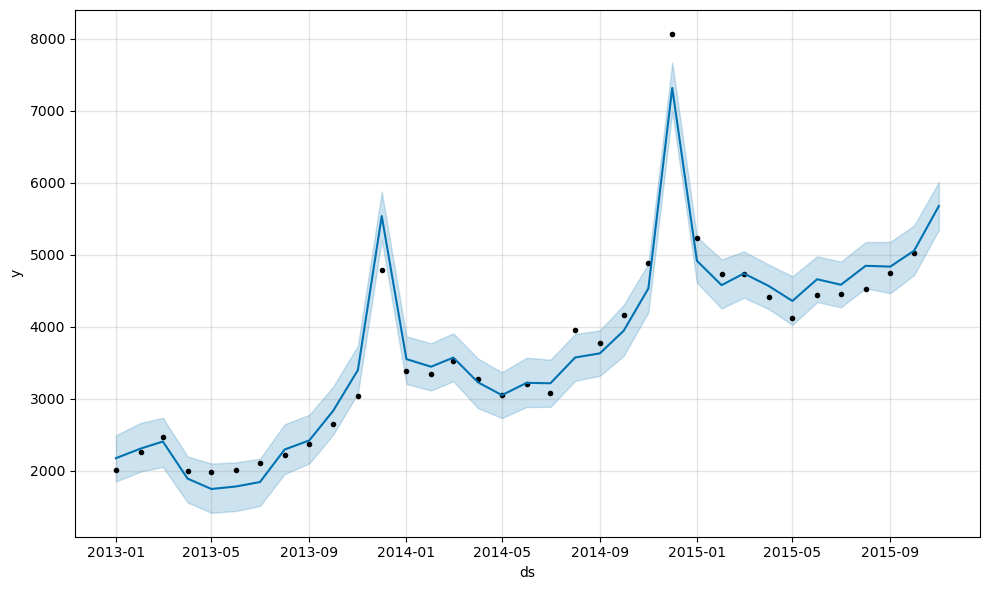

best_preds:  5676.312171287914

getting best preds for s31_ c0
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


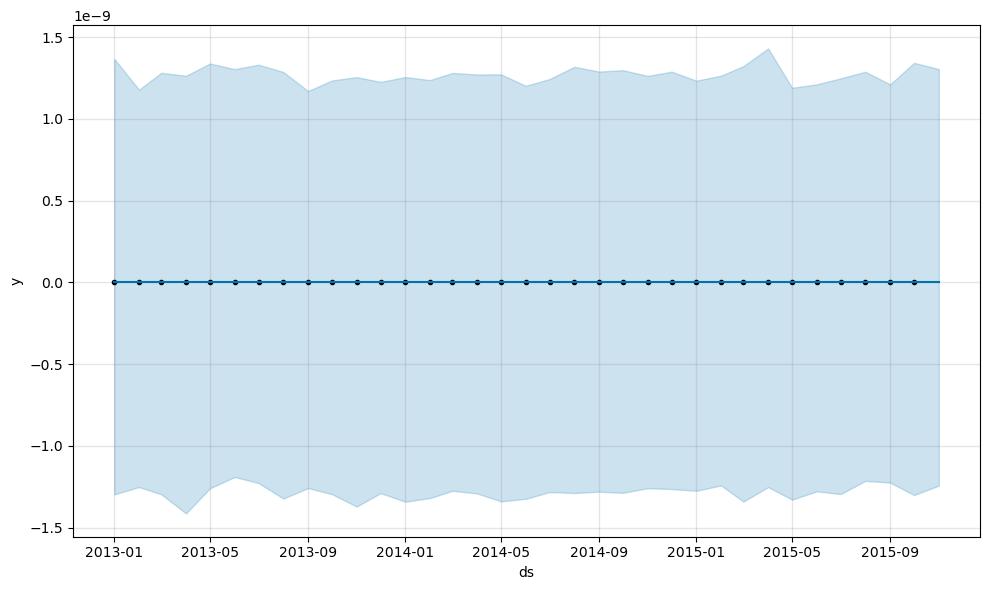

best_preds:  0.0

getting best preds for s31_ c11
2014-12-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.47       -0.08        1.05
33 2015-10-01  0.46       -0.12        1.05
34 2015-11-01  0.72        0.11        1.32


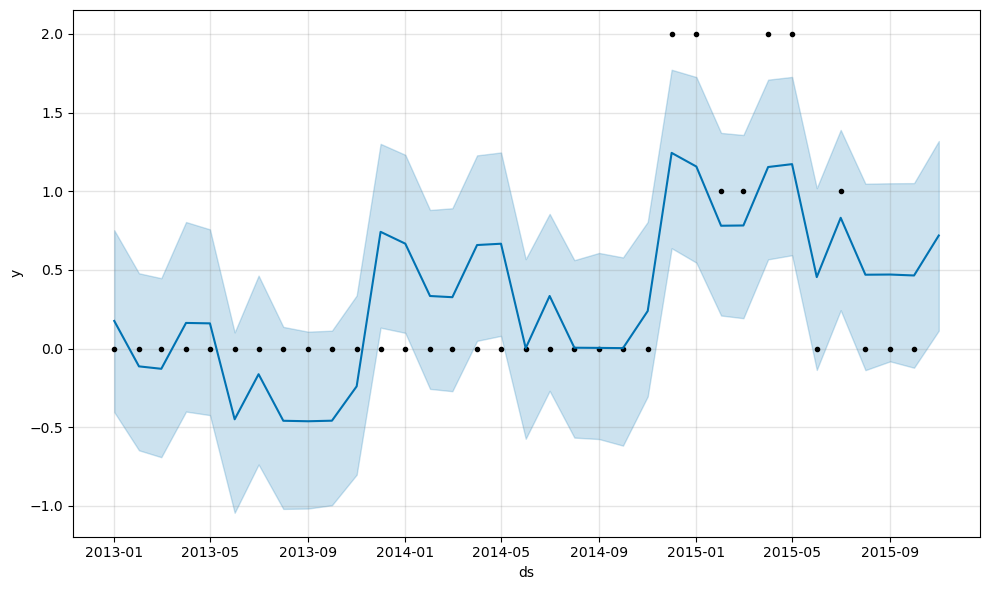

best_preds:  0.7188250179761648

getting best preds for s31_ c12
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 15.02        5.94       23.52
33 2015-10-01 15.28        6.32       24.90
34 2015-11-01 15.80        6.29       25.30


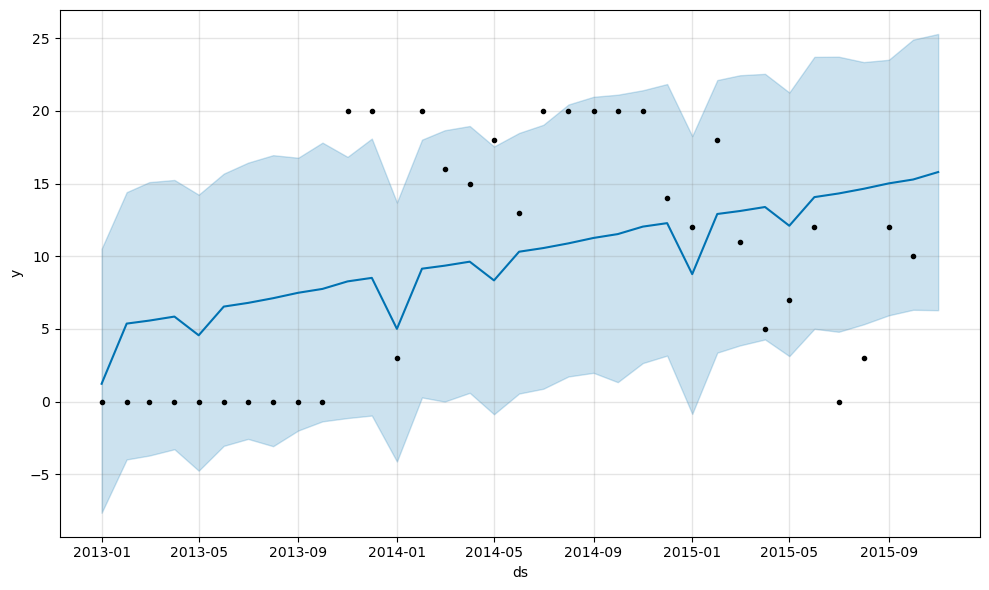

best_preds:  15.795663713132573

getting best preds for s31_ c15
2014-06-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  3.55        0.71        6.21
33 2015-10-01  3.78        1.11        6.68
34 2015-11-01  6.39        3.46        9.10


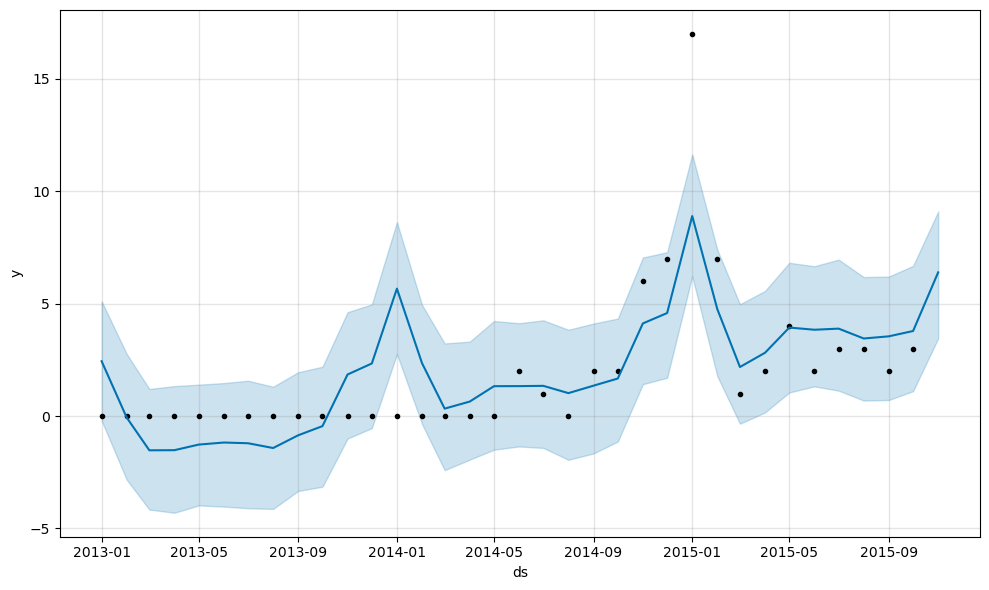

best_preds:  6.393000879845987

getting best preds for s31_ c16
2014-09-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  7.05        2.67       11.60
33 2015-10-01  2.37       -1.93        6.82
34 2015-11-01  3.77       -0.87        7.91


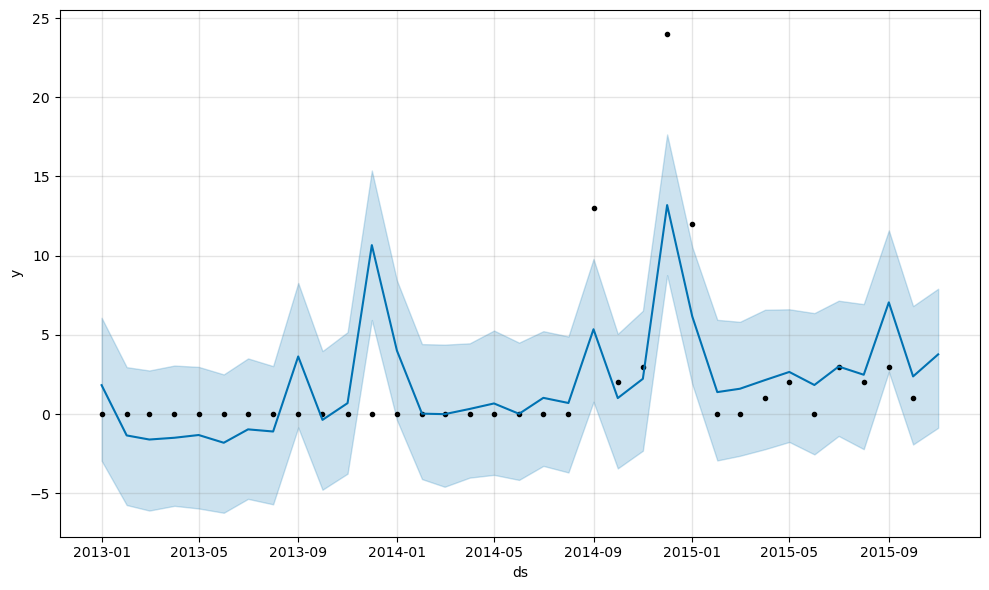

best_preds:  3.7671664431882927

getting best preds for s31_ c19
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 251.68      220.61      282.01
33 2015-10-01 181.86      152.31      211.19
34 2015-11-01 279.75      247.82      309.42


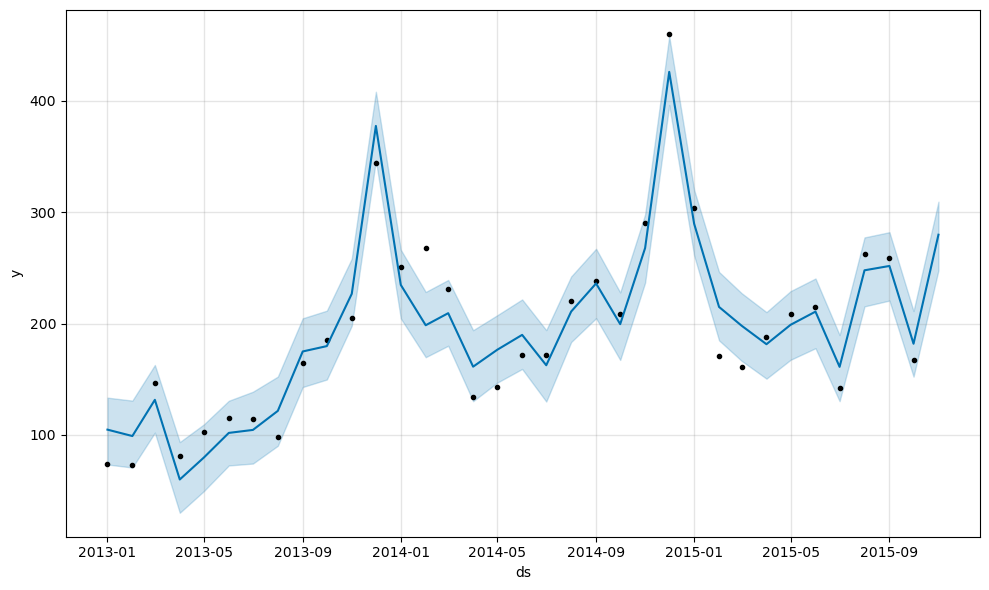

best_preds:  279.75471407965847

getting best preds for s31_ c2
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  9.90        3.74       15.75
33 2015-10-01 10.19        3.91       16.68
34 2015-11-01 19.47       13.09       25.60


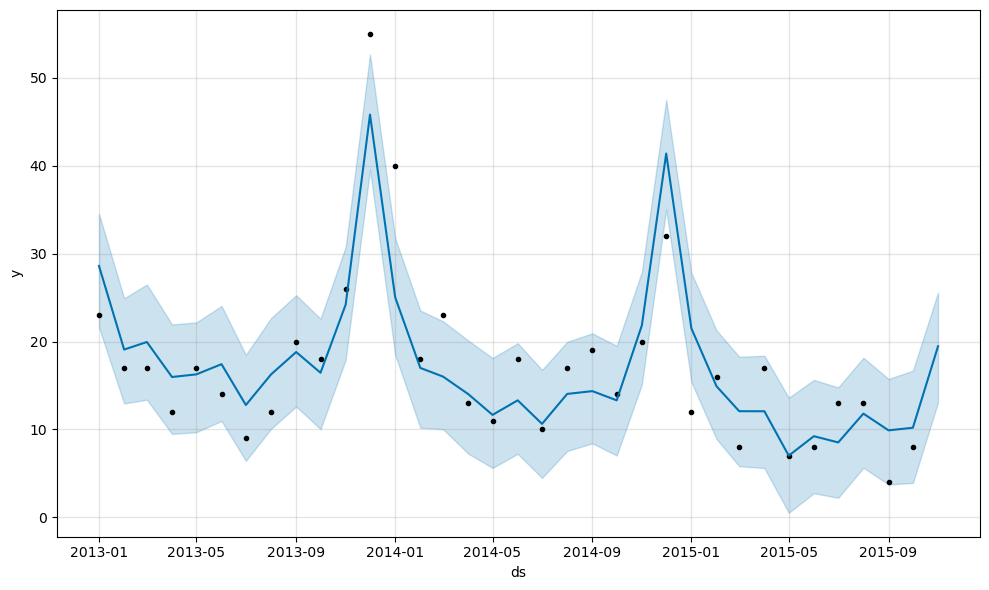

best_preds:  19.466369886298093

getting best preds for s31_ c20
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 329.20      300.73      357.98
33 2015-10-01 309.87      282.60      338.15
34 2015-11-01 350.56      321.10      381.99


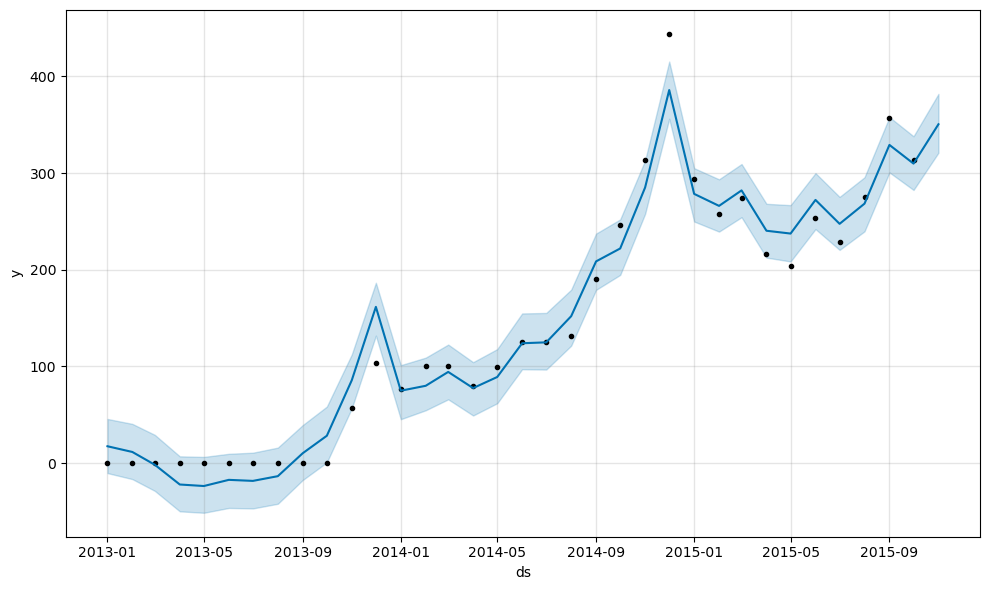

best_preds:  350.5634009022401

getting best preds for s31_ c21
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  4.40       -3.28       11.99
33 2015-10-01  4.03       -3.36       11.42
34 2015-11-01  3.90       -3.43       10.73


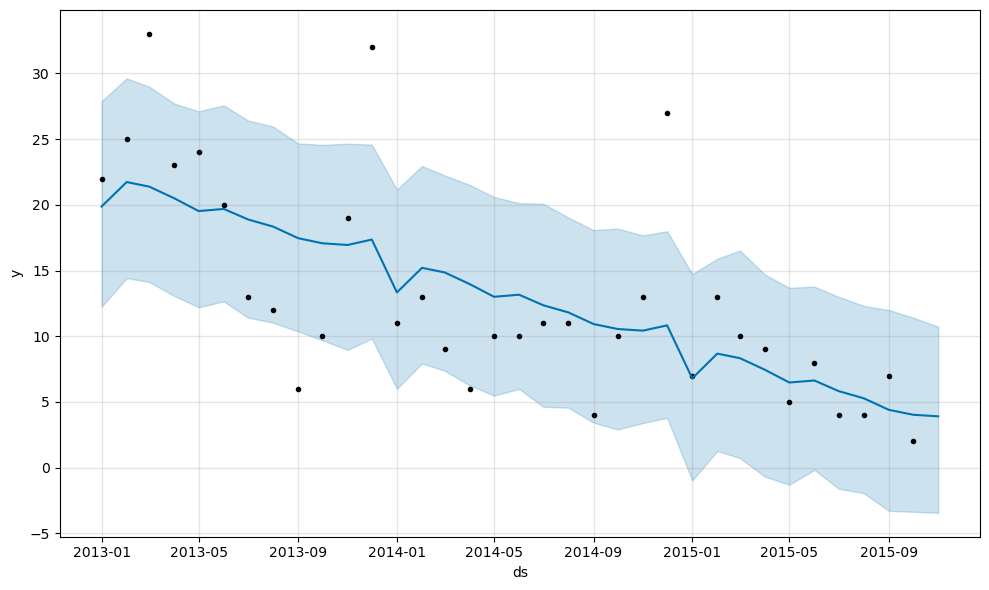

best_preds:  3.9040230949938097

getting best preds for s31_ c22
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 17.96       10.90       24.54
33 2015-10-01 11.62        4.56       19.13
34 2015-11-01 15.24        8.40       21.85


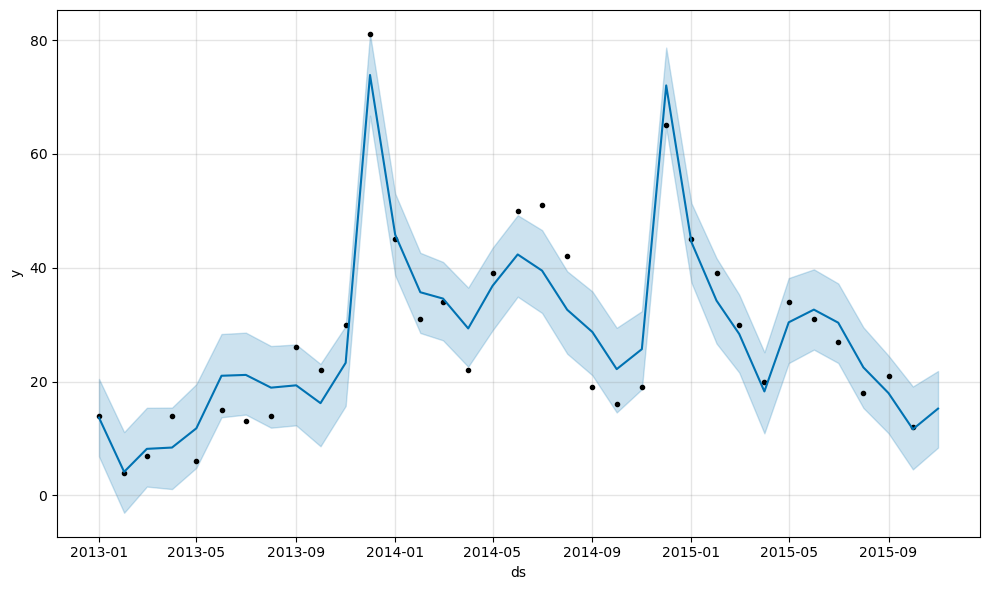

best_preds:  15.242544911388148

getting best preds for s31_ c23
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 226.54      195.02      258.56
33 2015-10-01 150.42      118.11      183.93
34 2015-11-01 249.14      215.59      278.87


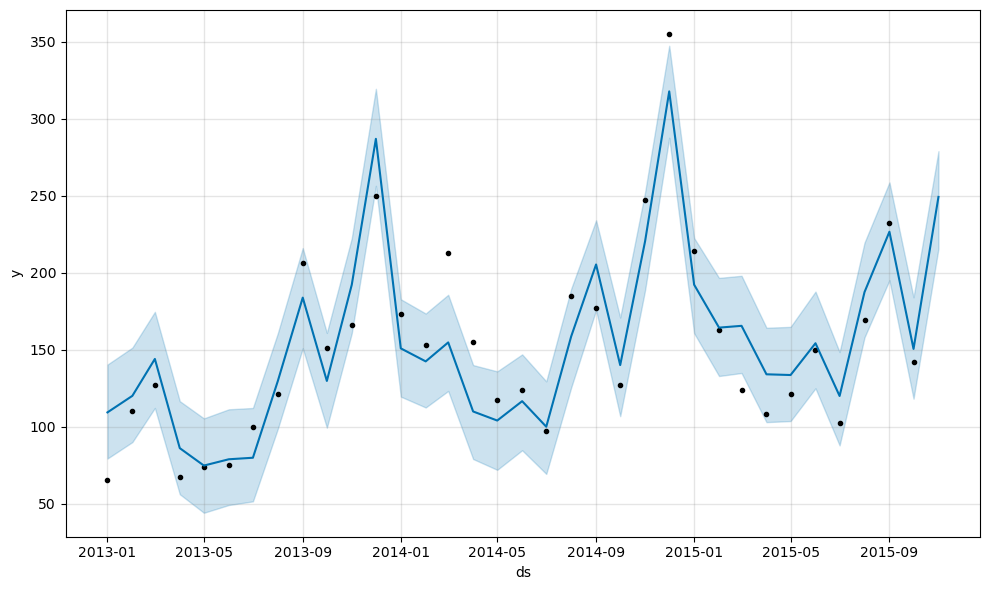

best_preds:  249.14429742925446

getting best preds for s31_ c24
2014-09-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 59.91       42.85       76.16
33 2015-10-01 66.45       48.27       83.65
34 2015-11-01 76.61       59.68       94.12


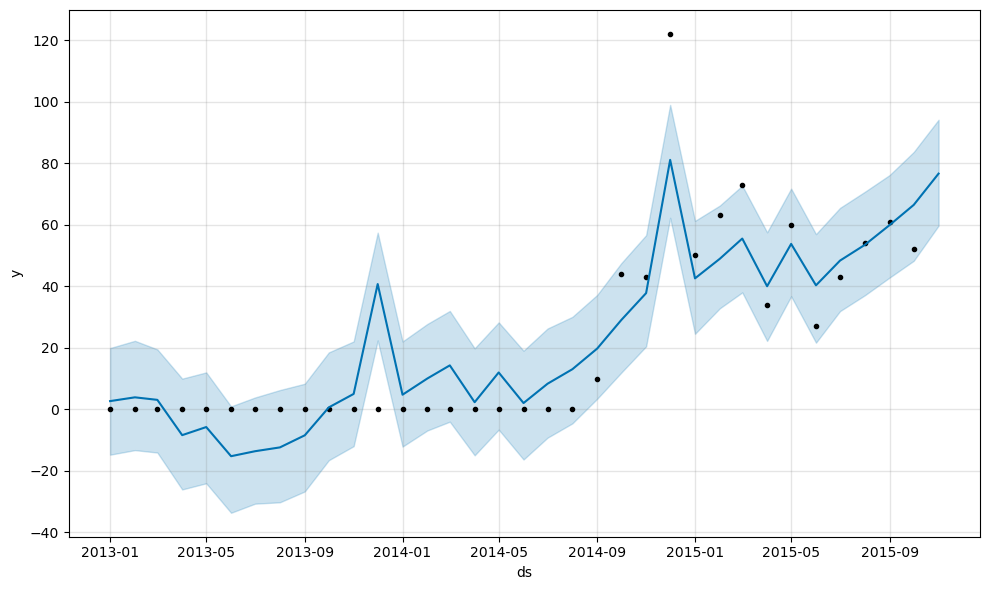

best_preds:  76.60907346694533

getting best preds for s31_ c25
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 21.69        5.05       38.69
33 2015-10-01 18.22       -1.52       35.97
34 2015-11-01 24.92        8.25       41.19


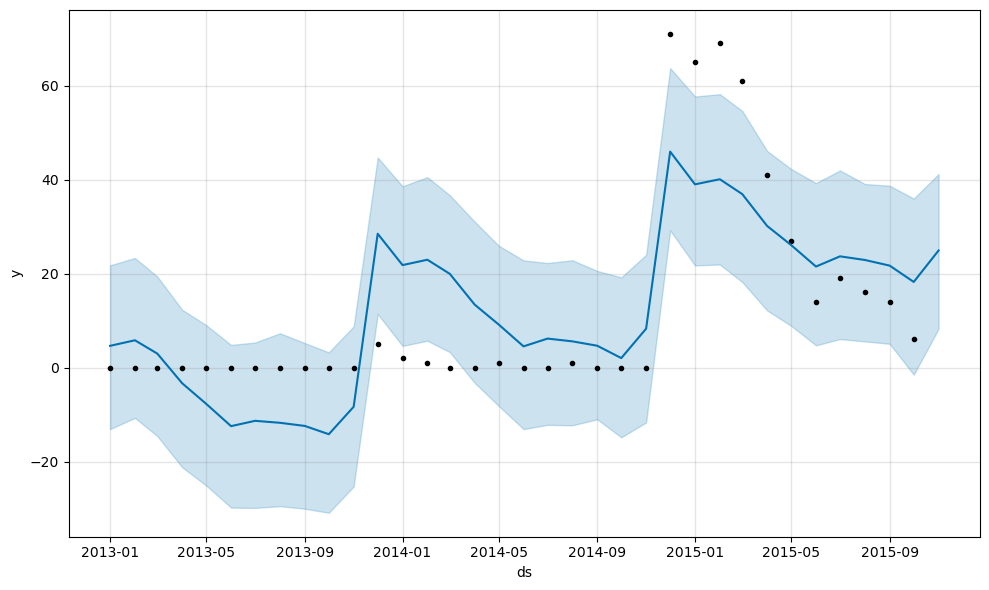

best_preds:  24.915077138383985

getting best preds for s31_ c26
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


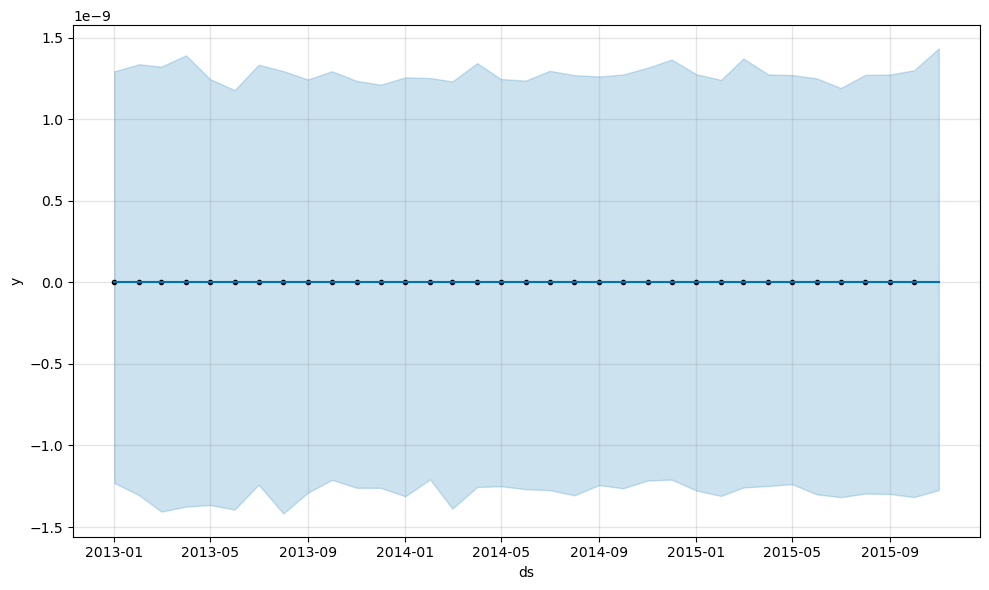

best_preds:  0.0

getting best preds for s31_ c27
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


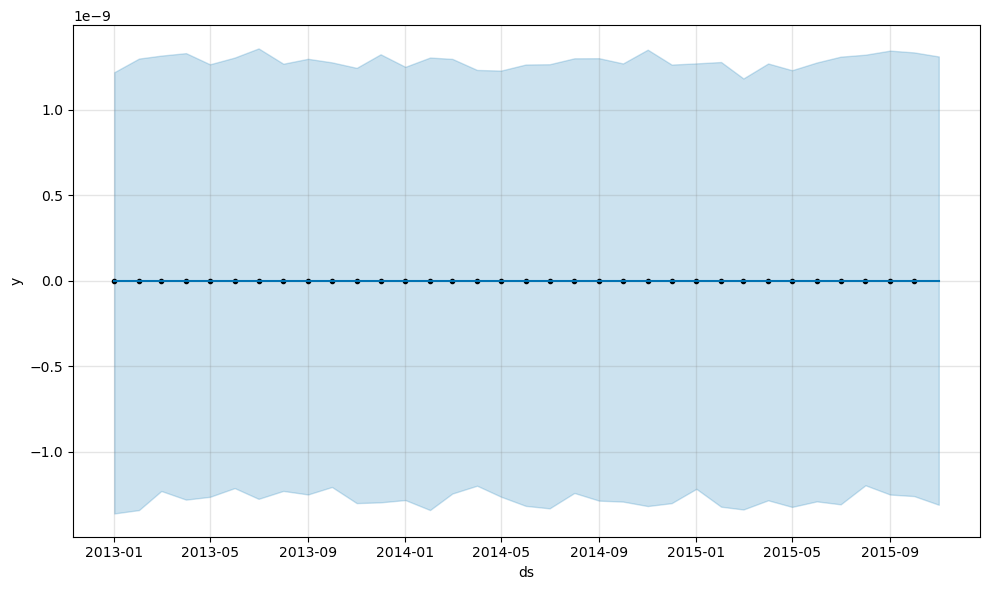

best_preds:  0.0

getting best preds for s31_ c28
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01  99.68       78.13      120.57
33 2015-10-01 108.06       88.39      129.80
34 2015-11-01 133.48      113.96      154.17


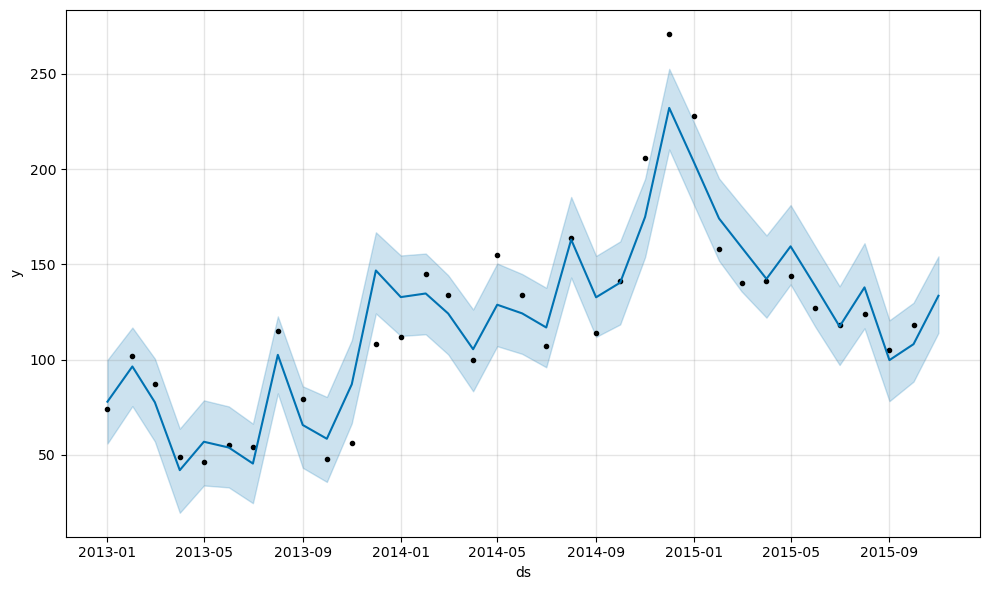

best_preds:  133.47889432368896

getting best preds for s31_ c29
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 13.45        0.63       26.34
33 2015-10-01 13.41        0.74       26.89
34 2015-11-01 14.80        1.88       28.81


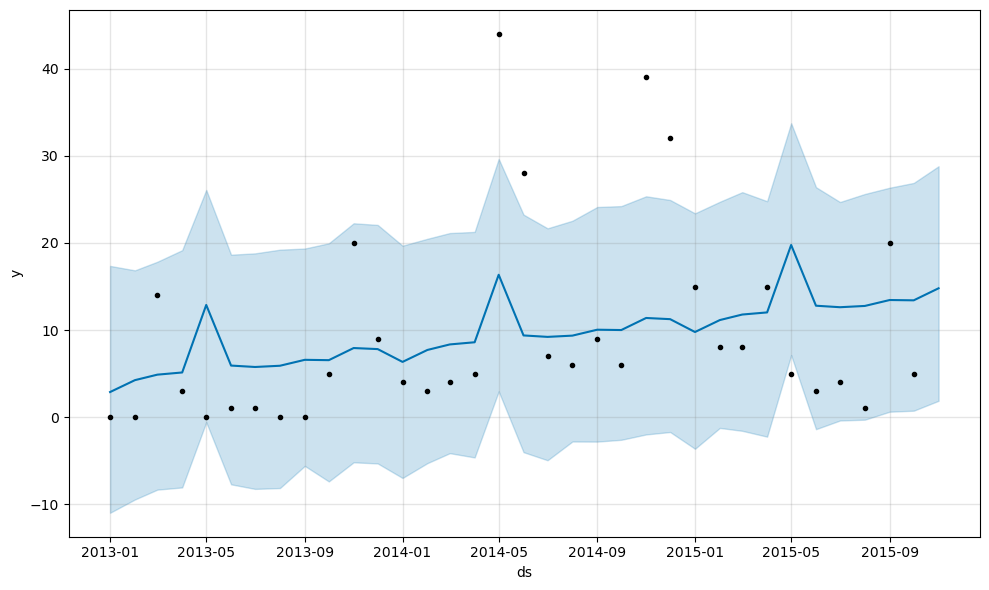

best_preds:  14.795520862678856

getting best preds for s31_ c3
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 71.59       61.32       81.68
33 2015-10-01 69.48       59.70       80.14
34 2015-11-01 72.34       63.06       82.23


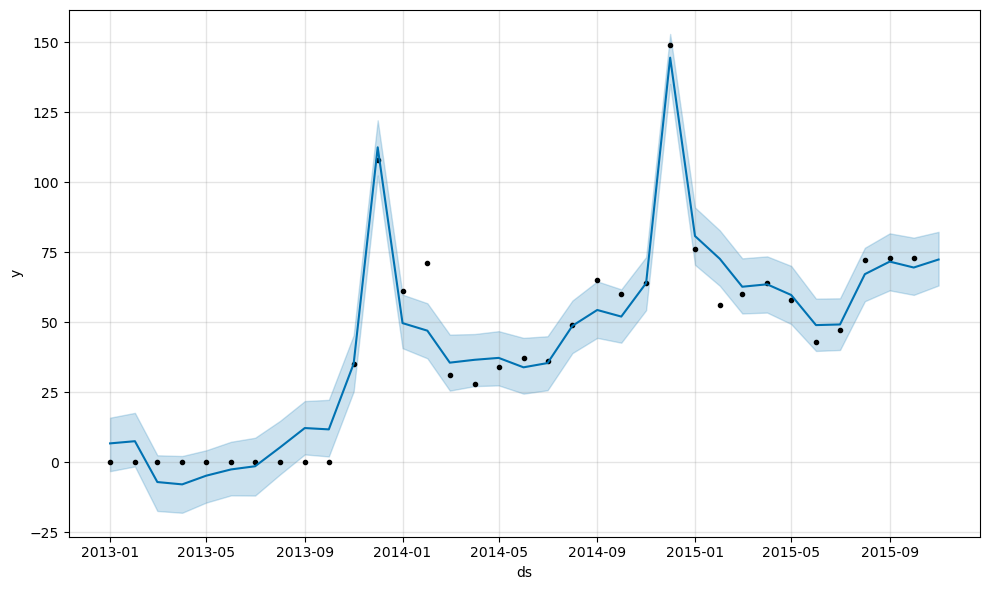

best_preds:  72.34308661580631

getting best preds for s31_ c30
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 259.78      215.26      307.75
33 2015-10-01 229.94      181.97      275.04
34 2015-11-01 213.44      165.45      260.58


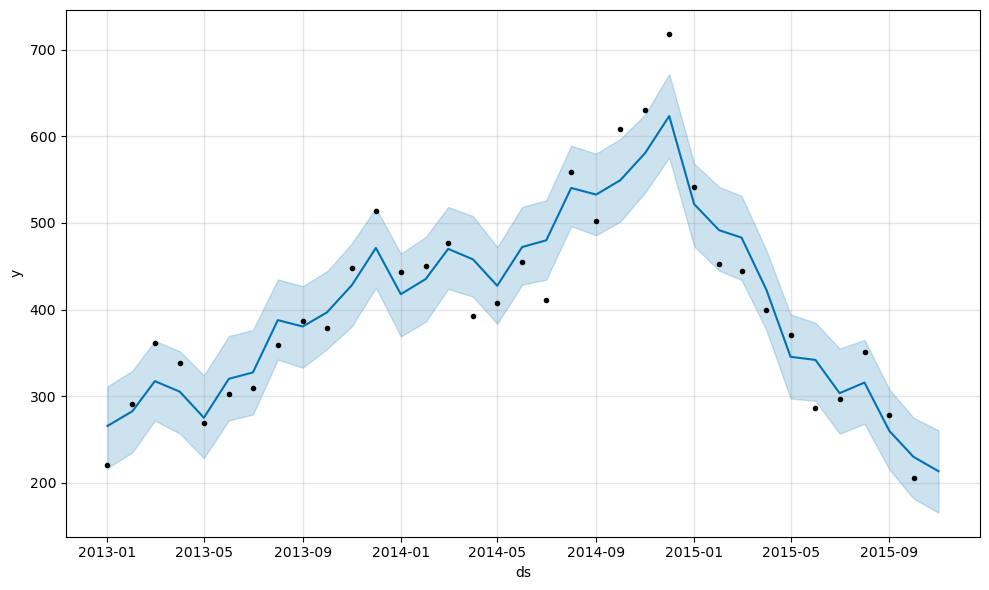

best_preds:  213.43643932512242

getting best preds for s31_ c31
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


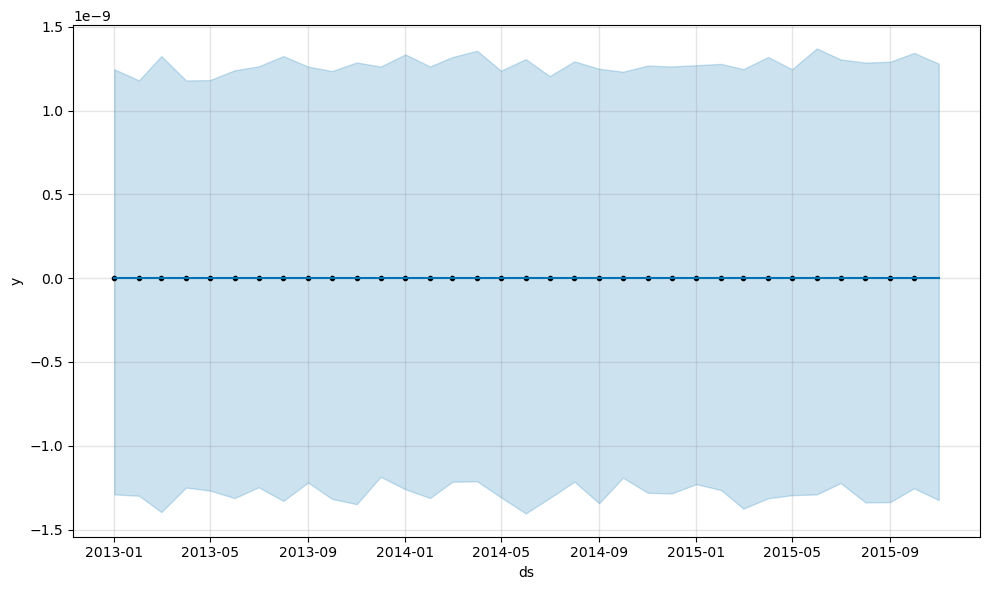

best_preds:  0.0

getting best preds for s31_ c33
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 11.33        9.17       13.53
33 2015-10-01 11.74        9.83       13.79
34 2015-11-01 12.49       10.39       14.64


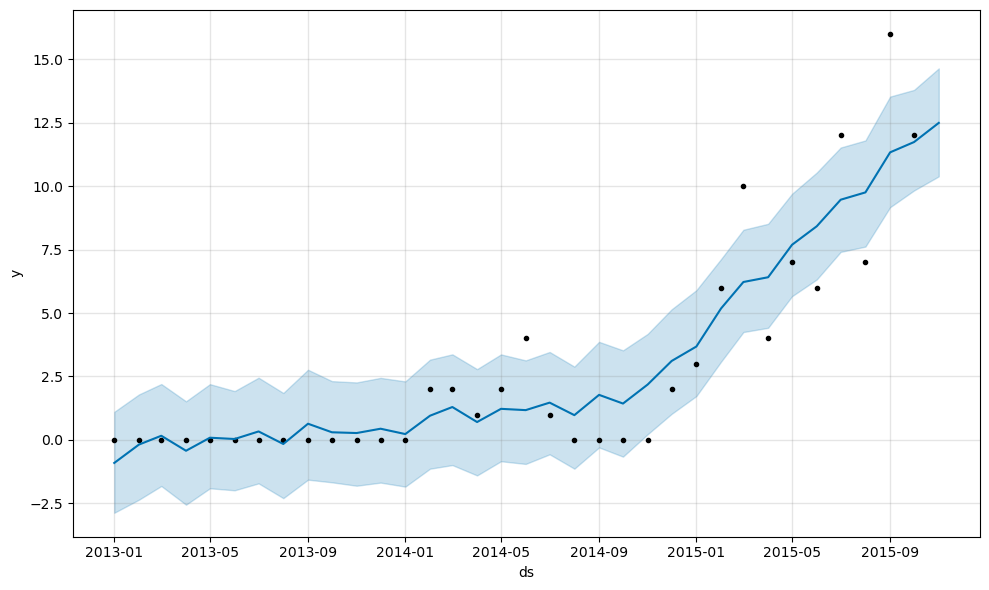

best_preds:  12.494111200574237

getting best preds for s31_ c34
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


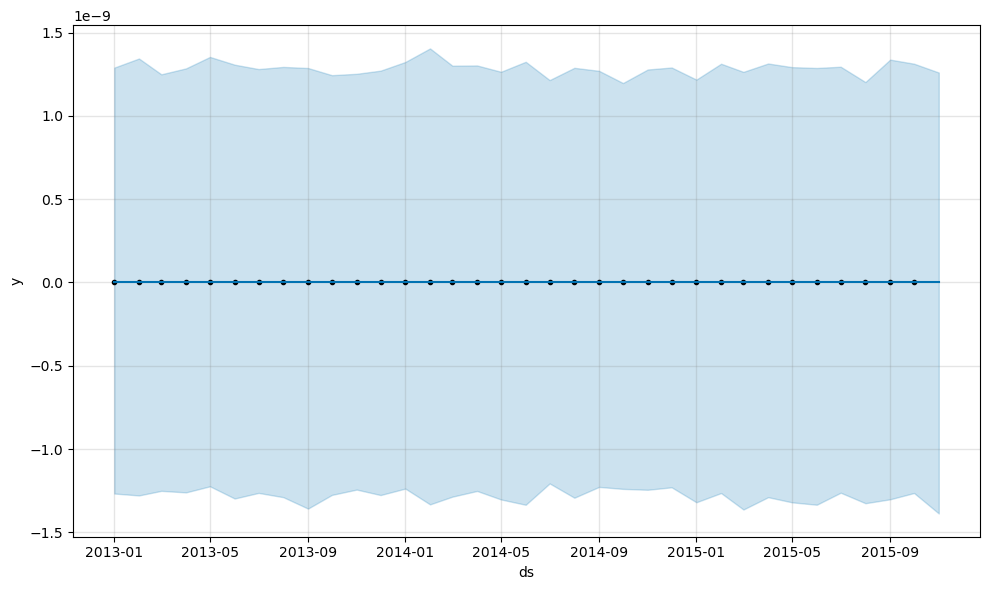

best_preds:  0.0

getting best preds for s31_ c35
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 59.74       48.35       71.62
33 2015-10-01 55.87       45.34       66.87
34 2015-11-01 57.48       46.73       68.03


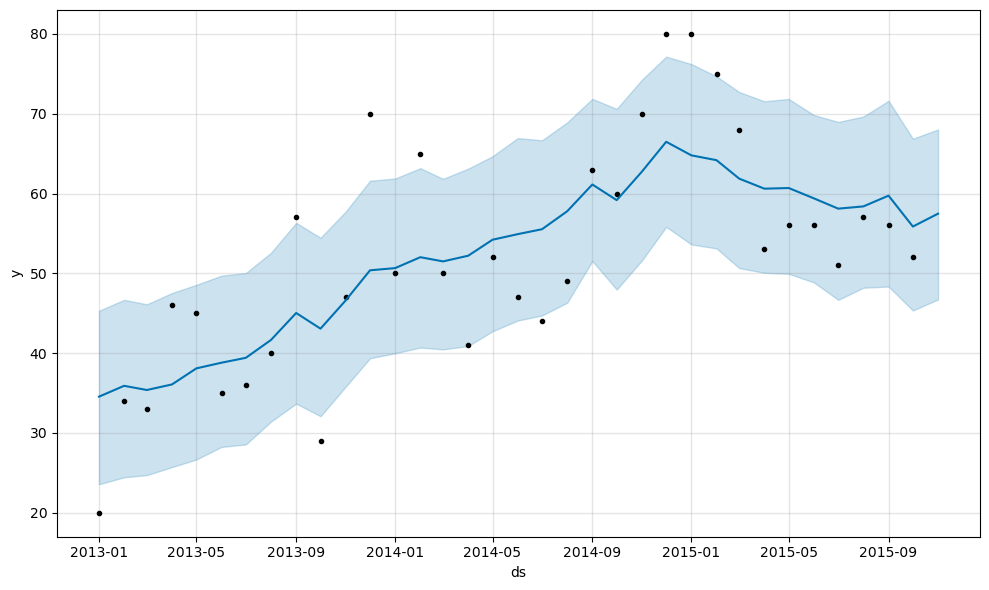

best_preds:  57.48026713082075

getting best preds for s31_ c36
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


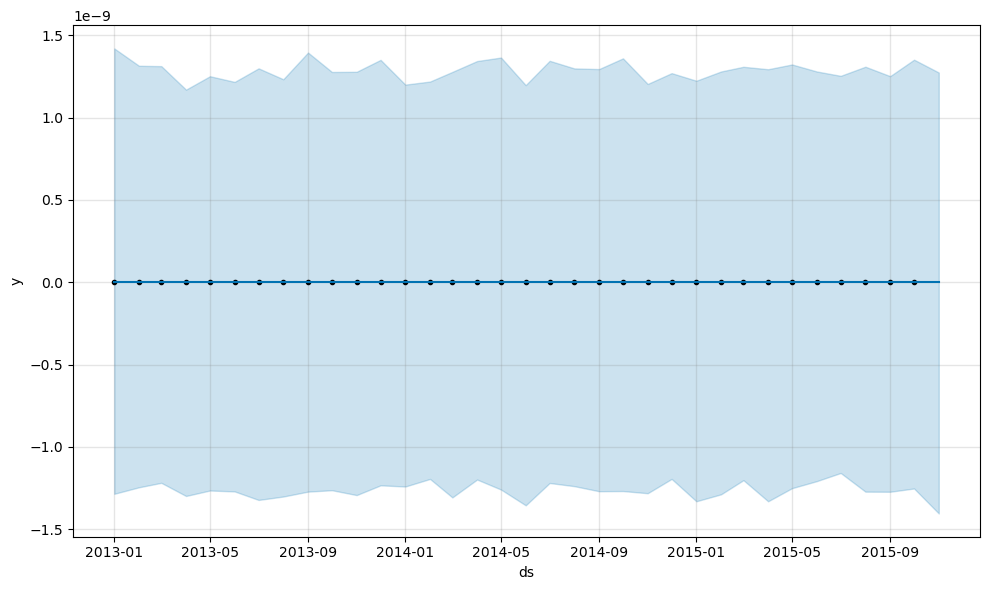

best_preds:  0.0

getting best preds for s31_ c37
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 254.09      221.53      286.69
33 2015-10-01 278.87      246.27      311.36
34 2015-11-01 273.27      240.75      306.96


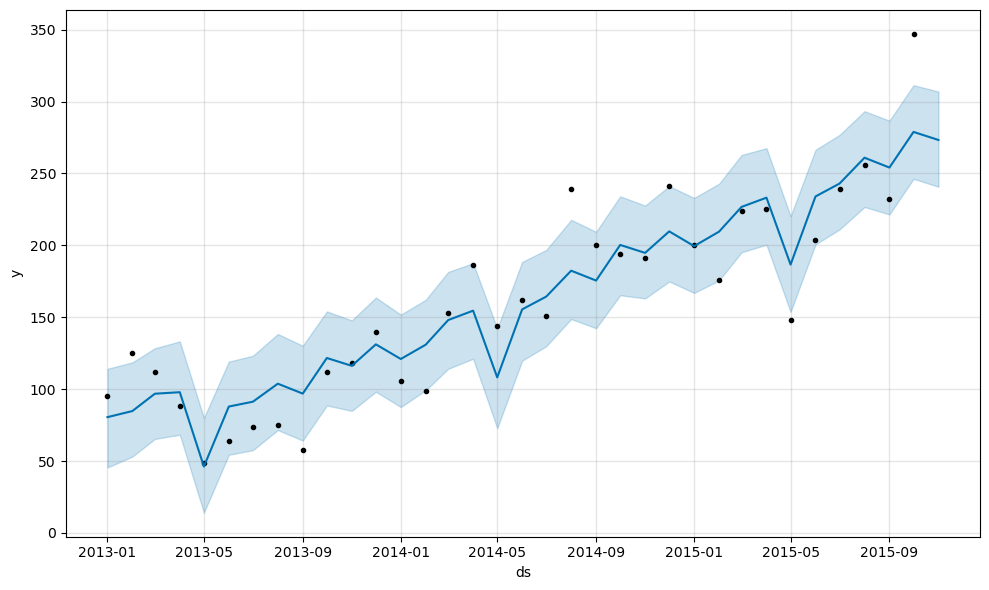

best_preds:  273.274053946945

getting best preds for s31_ c38
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 77.86       48.03      106.31
33 2015-10-01 79.15       51.67      106.30
34 2015-11-01 80.69       52.32      108.25


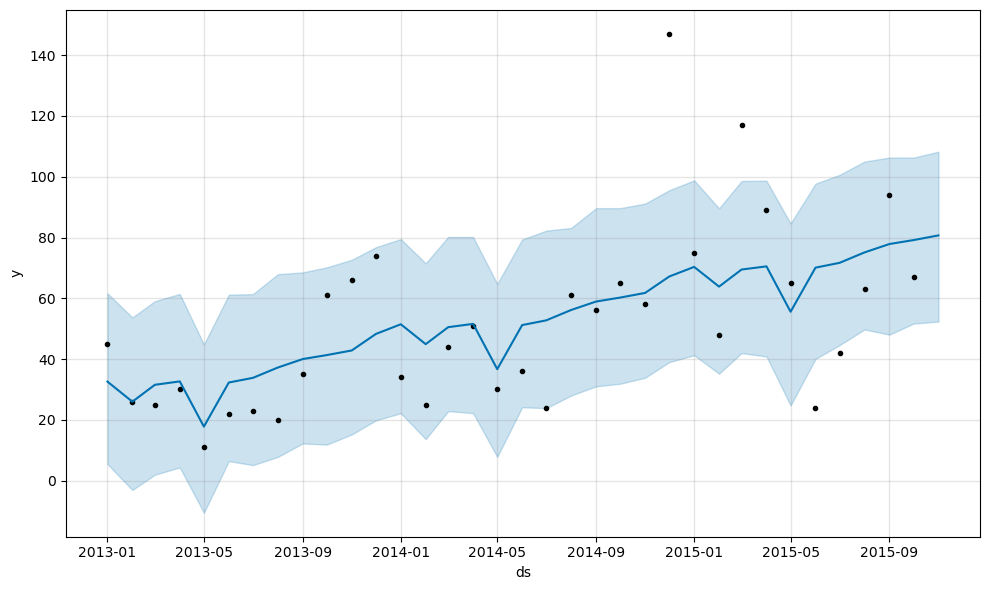

best_preds:  80.69248816072789

getting best preds for s31_ c40
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds     yhat  yhat_lower  yhat_upper
32 2015-09-01 1,012.85      924.85    1,092.93
33 2015-10-01 1,107.22    1,022.84    1,192.13
34 2015-11-01 1,147.61    1,065.09    1,235.10


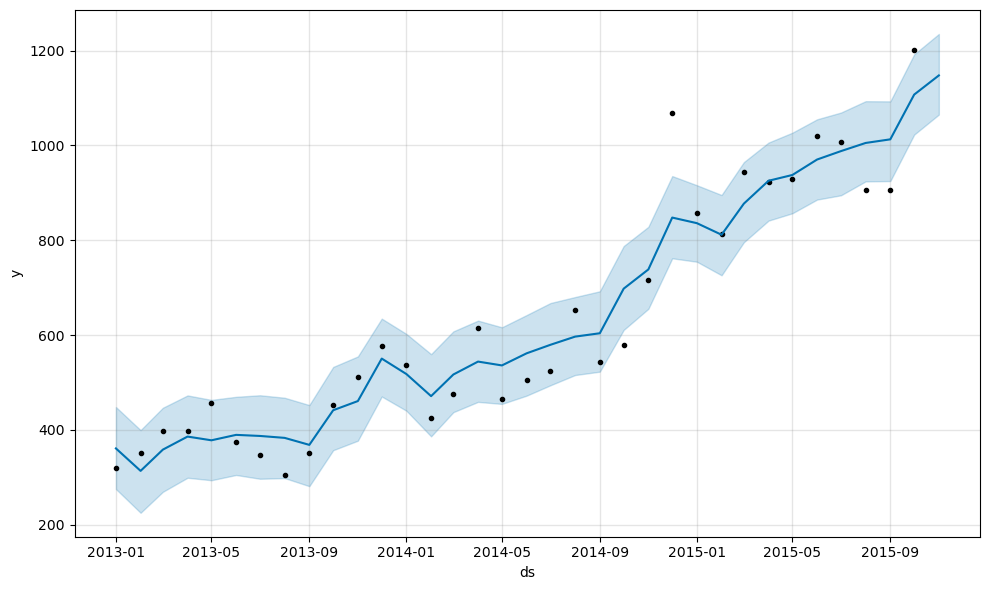

best_preds:  1147.611485226922

getting best preds for s31_ c41
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 42.30       33.10       52.27
33 2015-10-01 43.76       34.46       53.06
34 2015-11-01 55.80       46.93       65.17


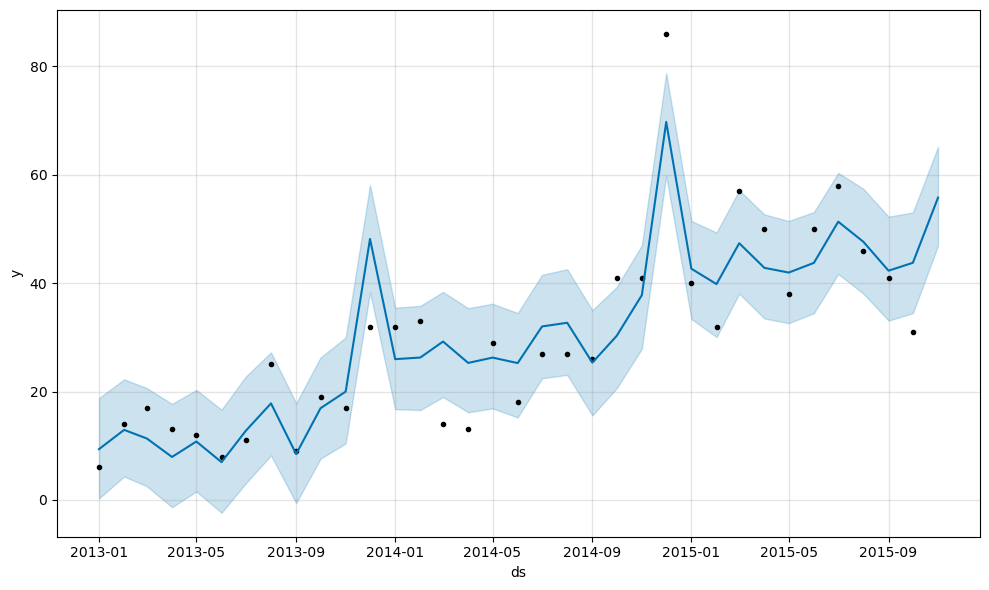

best_preds:  55.79715835545417

getting best preds for s31_ c42
2015-05-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 37.72       35.14       40.40
33 2015-10-01 39.40       36.77       42.06
34 2015-11-01 47.85       45.32       50.54


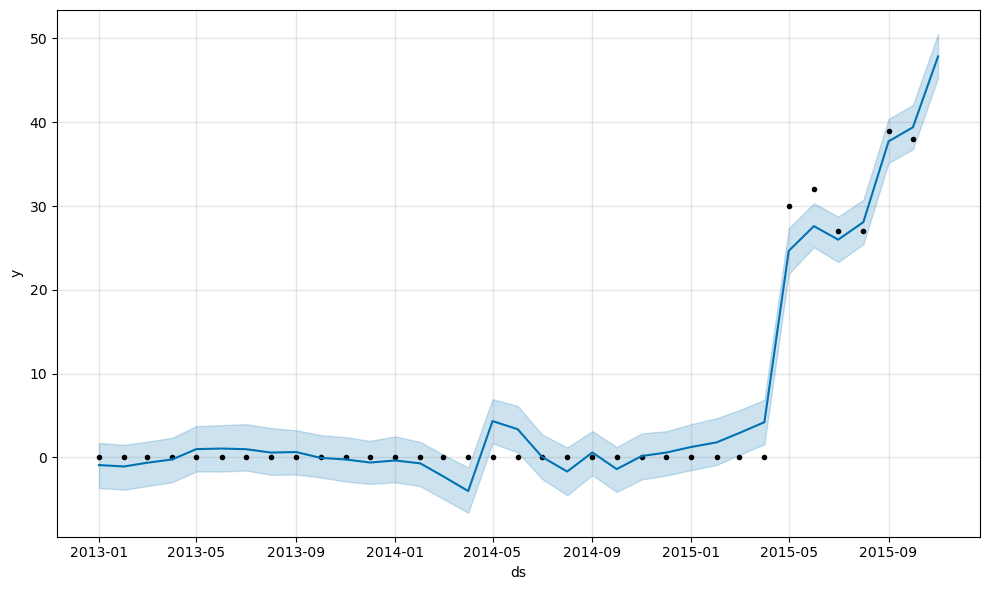

best_preds:  47.85172619312622

getting best preds for s31_ c43
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 48.21       38.73       58.44
33 2015-10-01 65.98       55.80       75.39
34 2015-11-01 64.21       54.97       73.12


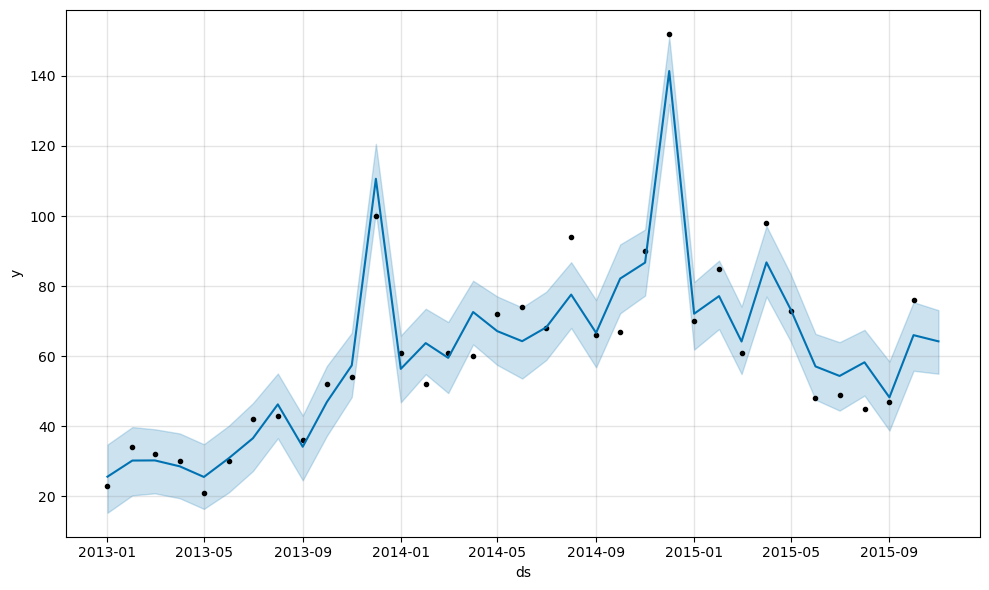

best_preds:  64.20845151935727

getting best preds for s31_ c44
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


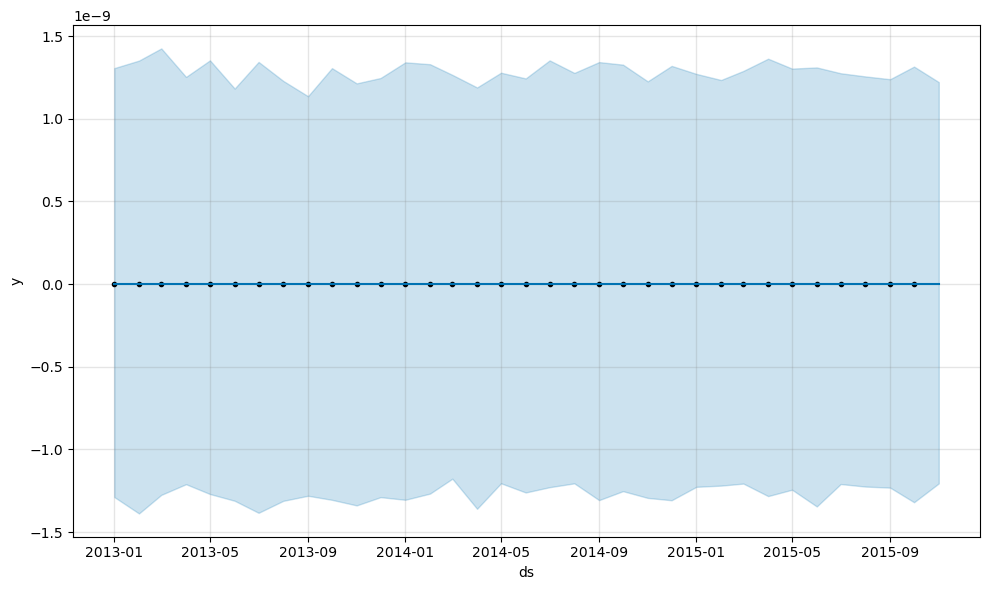

best_preds:  0.0

getting best preds for s31_ c45
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.23       10.55       17.97
33 2015-10-01 20.04       16.50       23.80
34 2015-11-01 22.70       18.68       26.41


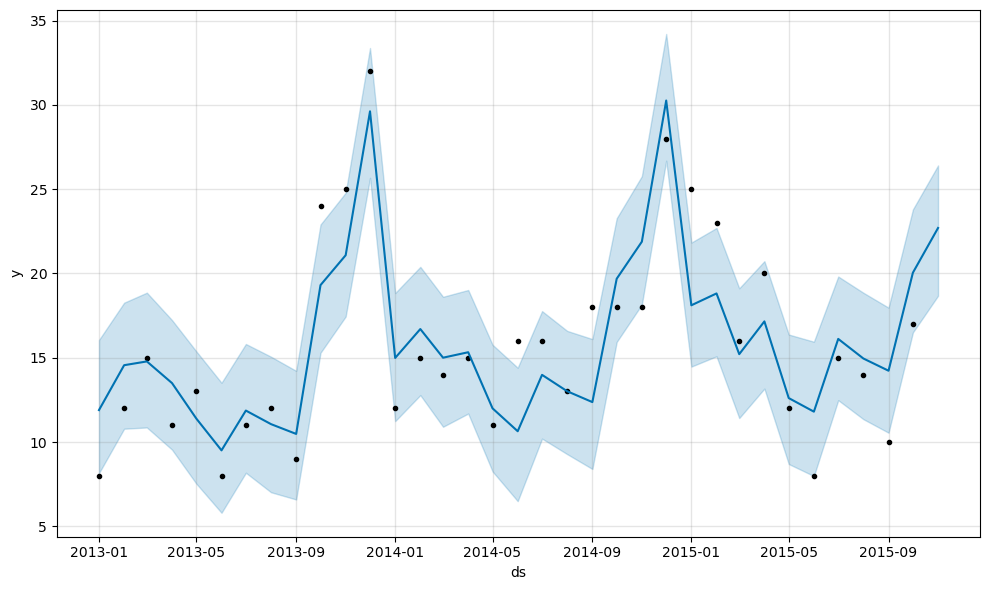

best_preds:  22.697175889919066

getting best preds for s31_ c47
2015-03-01 00:00:00
too many zero values, return default best params
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 118.96      111.30      127.63
33 2015-10-01 154.35      146.26      162.65
34 2015-11-01 134.92      126.70      142.76


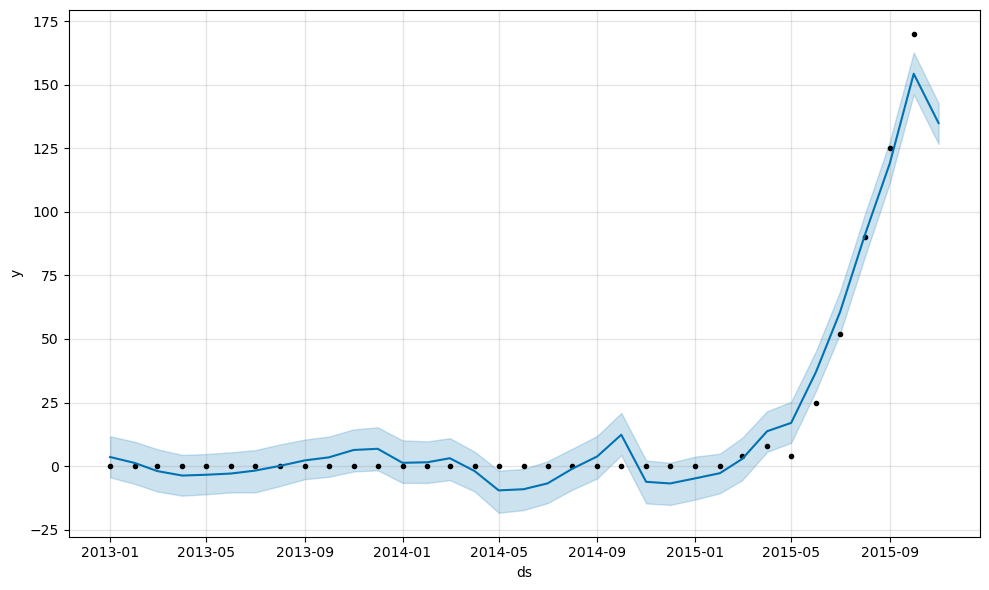

best_preds:  134.92010308170998

getting best preds for s31_ c49
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 23.48       15.48       31.86
33 2015-10-01 34.28       25.67       42.57
34 2015-11-01 29.32       20.99       37.46


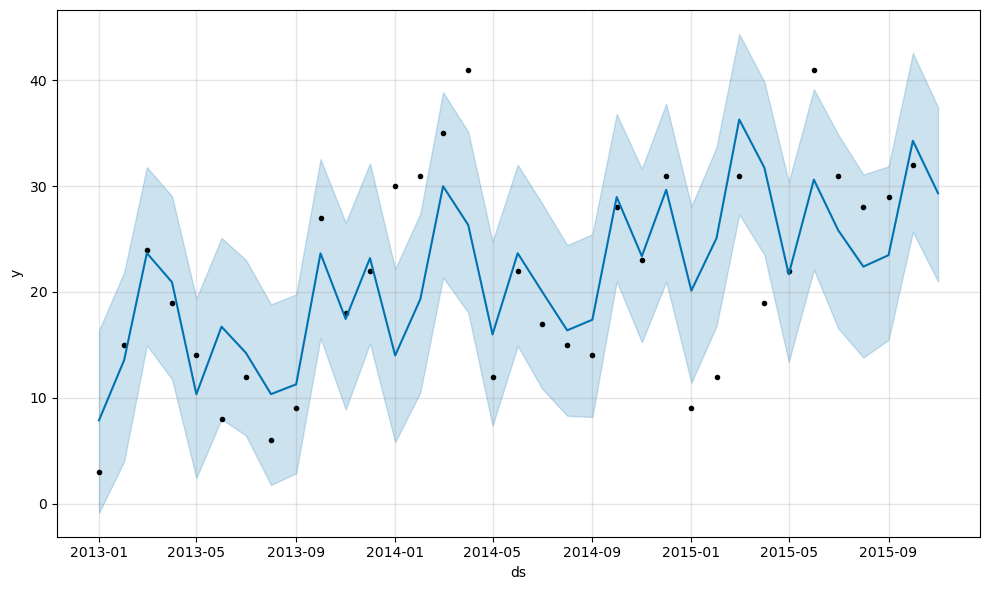

best_preds:  29.32443880663178

getting best preds for s31_ c5
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.96        0.70        3.40
33 2015-10-01  4.69        3.27        6.06
34 2015-11-01 -1.33       -2.85        0.06


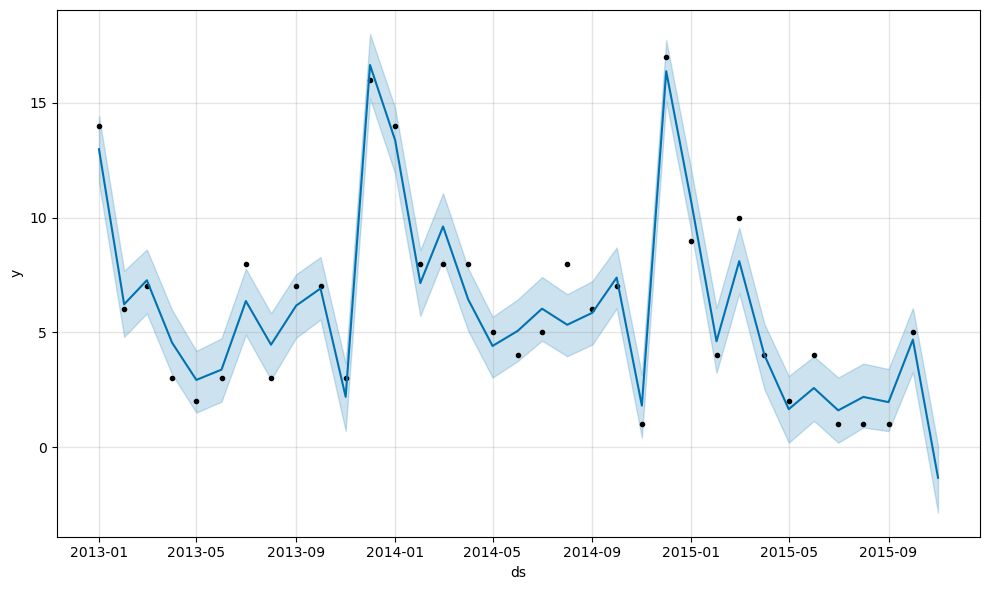

best_preds:  -1.3286080631439514

getting best preds for s31_ c54
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


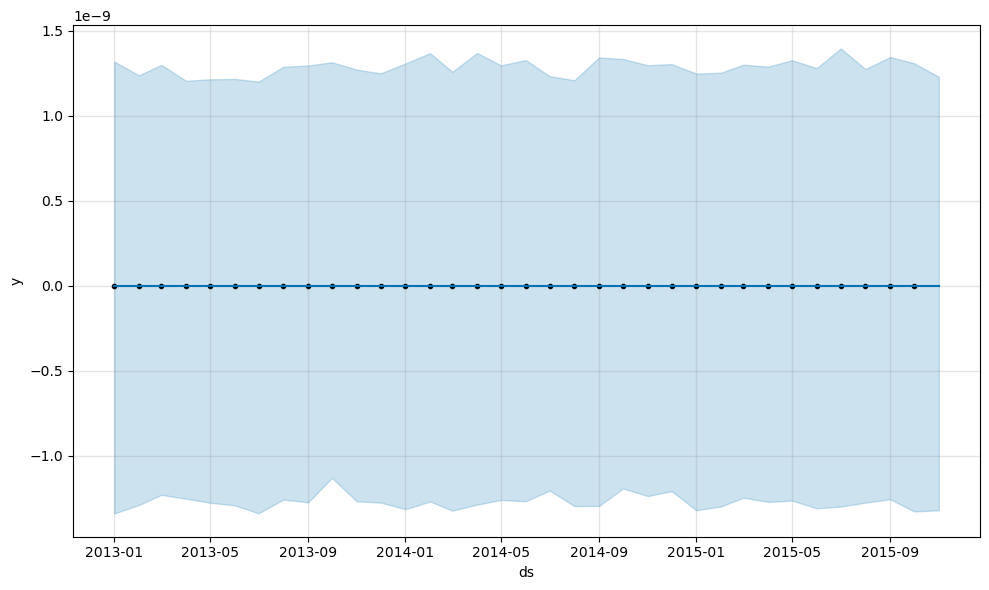

best_preds:  0.0

getting best preds for s31_ c55
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 537.55      438.87      647.62
33 2015-10-01 547.91      450.52      652.50
34 2015-11-01 521.53      418.94      626.49


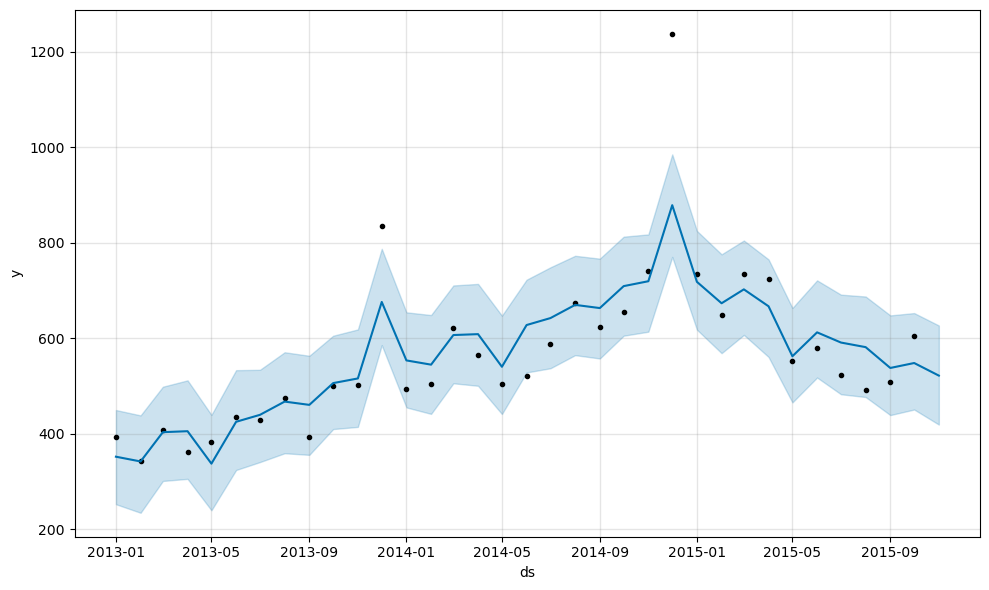

best_preds:  521.5339238023404

getting best preds for s31_ c56
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 21.12       13.06       28.59
33 2015-10-01 12.75        4.45       19.88
34 2015-11-01 26.43       18.52       34.33


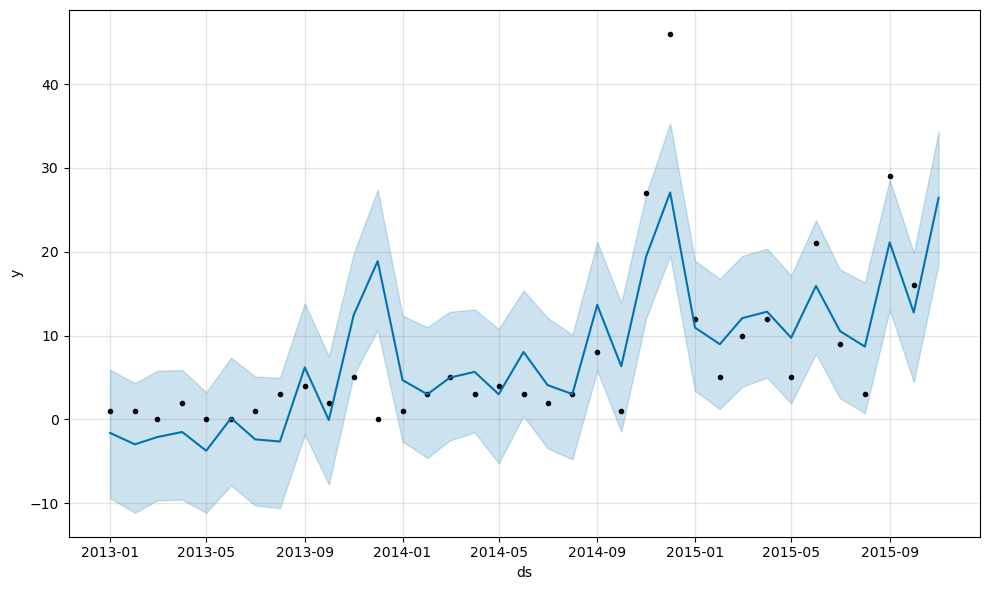

best_preds:  26.427927621743038

getting best preds for s31_ c57
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 105.66       77.58      132.78
33 2015-10-01 104.99       79.08      131.70
34 2015-11-01 108.95       84.36      134.39


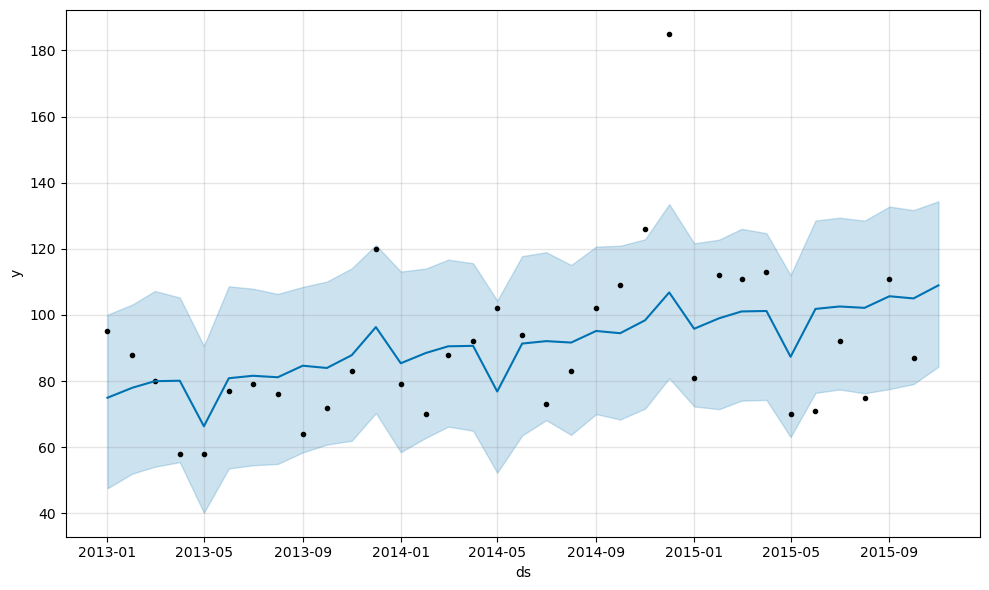

best_preds:  108.9530649676205

getting best preds for s31_ c58
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 30.35       24.59       36.21
33 2015-10-01 35.74       30.04       42.03
34 2015-11-01 38.22       32.22       44.58


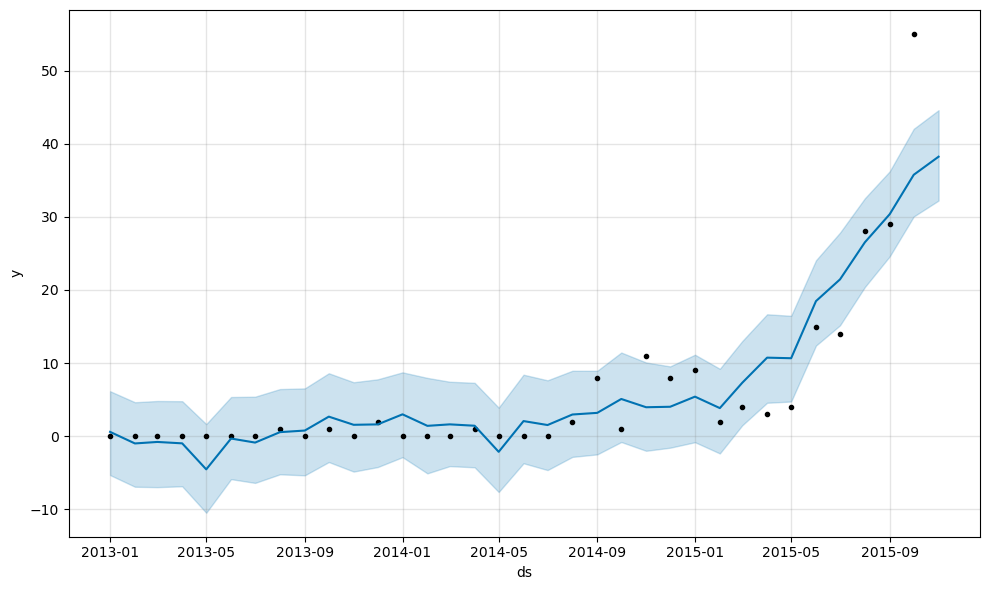

best_preds:  38.21741466902505

getting best preds for s31_ c6
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 22.16       16.61       27.90
33 2015-10-01 26.22       20.59       32.07
34 2015-11-01 33.24       27.49       39.04


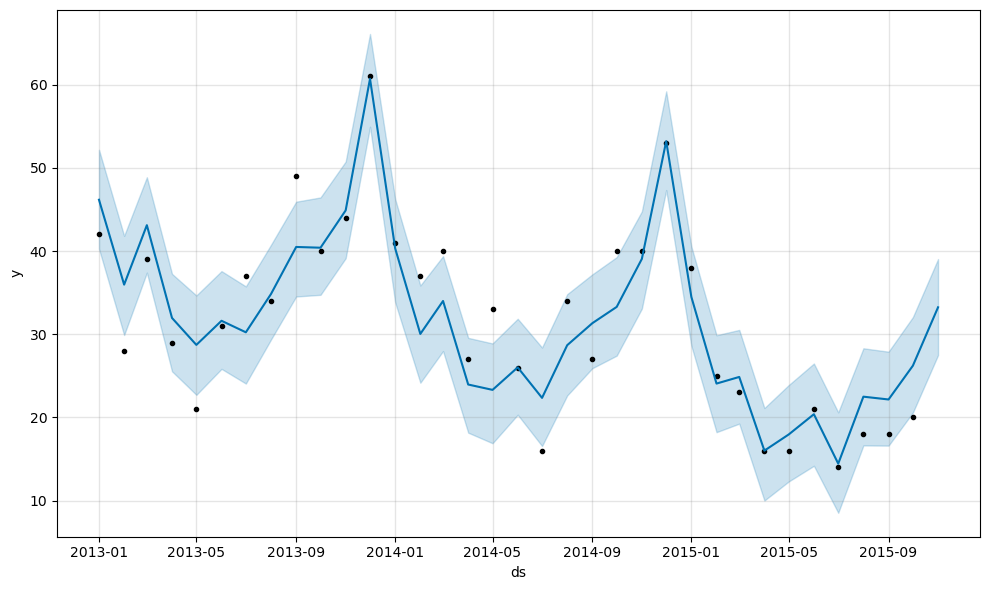

best_preds:  33.24184891222359

getting best preds for s31_ c60
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  1.87        0.65        3.12
33 2015-10-01  1.88        0.67        3.10
34 2015-11-01  1.95        0.71        3.17


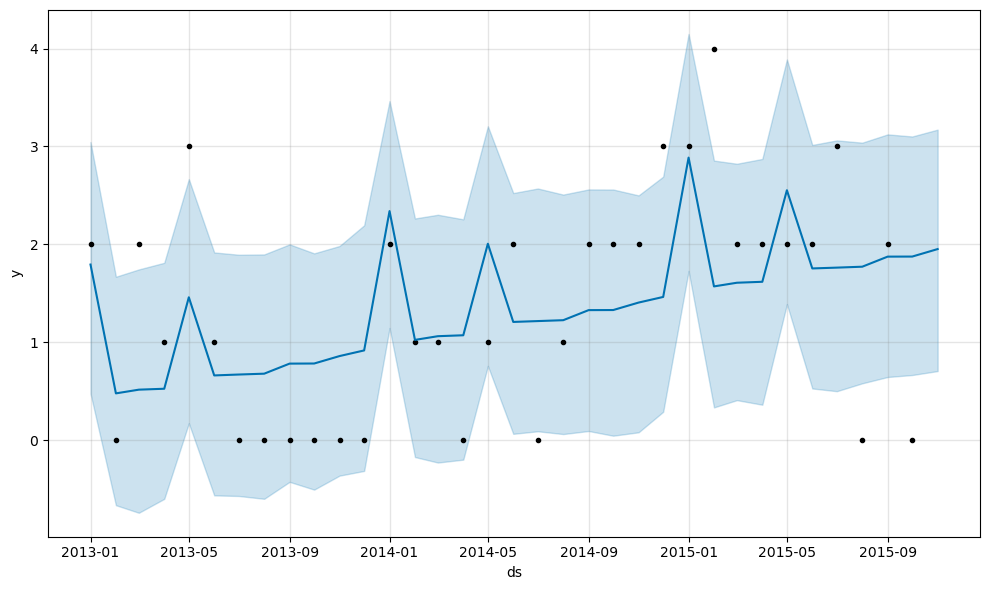

best_preds:  1.95189692527502

getting best preds for s31_ c61
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 67.20       57.11       77.16
33 2015-10-01 73.44       63.27       83.74
34 2015-11-01 77.02       67.20       87.42


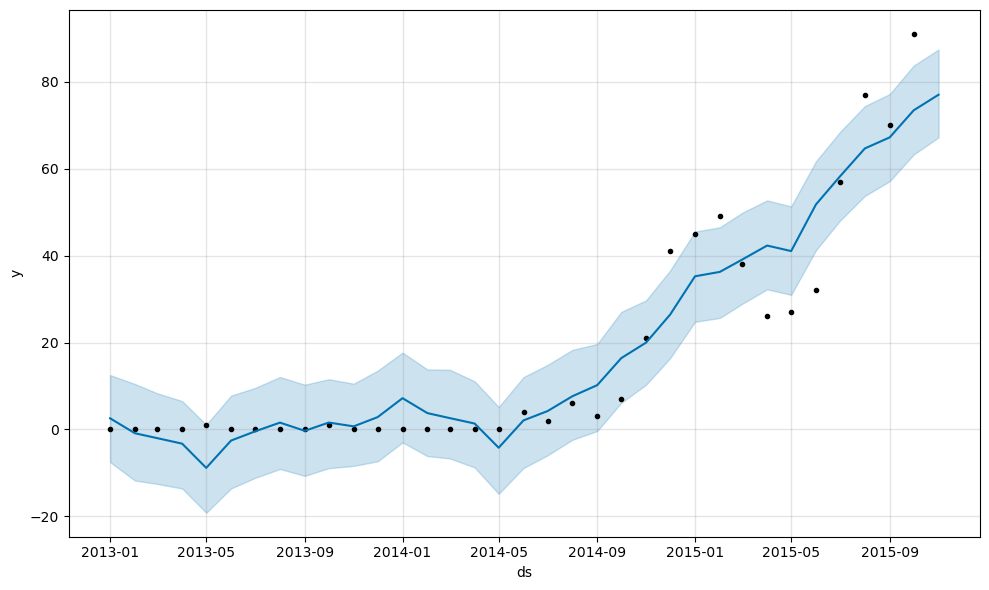

best_preds:  77.01780069149801

getting best preds for s31_ c62
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 14.75       -3.73       32.41
33 2015-10-01 14.73       -1.93       33.73
34 2015-11-01 13.91       -5.36       31.19


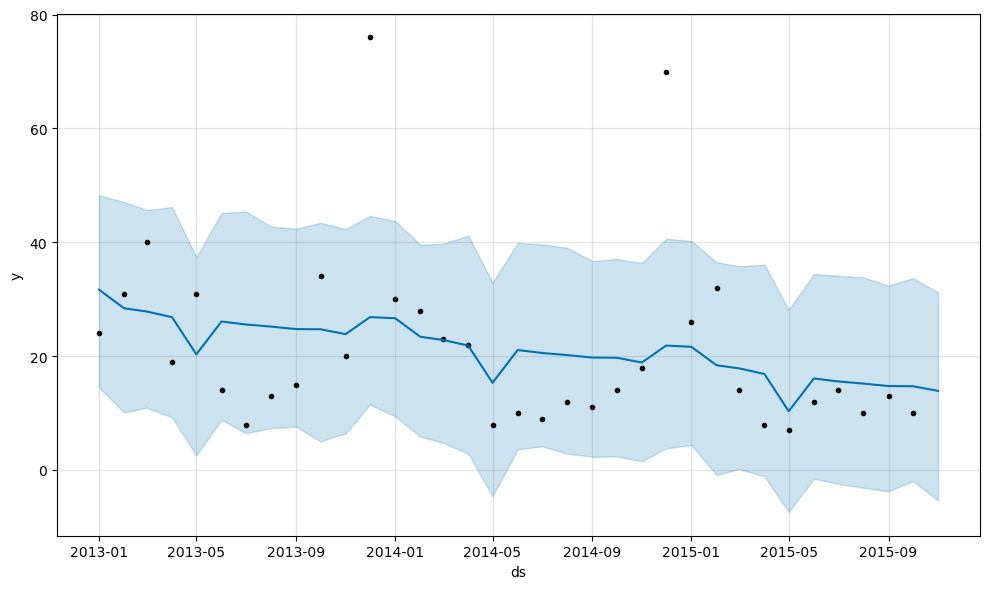

best_preds:  13.906829503049272

getting best preds for s31_ c63
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 252.63      197.23      308.78
33 2015-10-01 259.93      202.56      317.75
34 2015-11-01 265.86      210.50      324.06


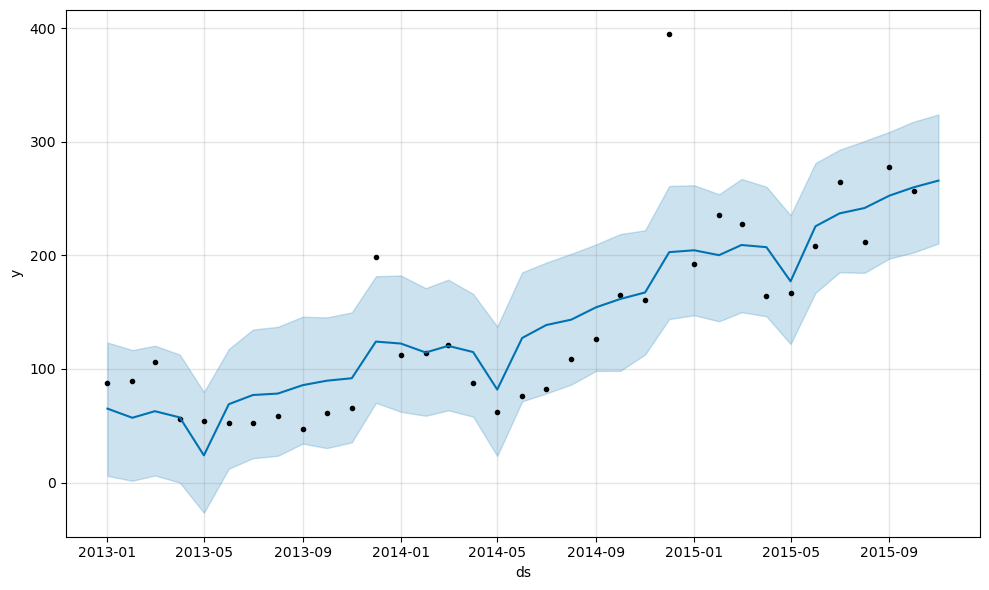

best_preds:  265.85778836132096

getting best preds for s31_ c64
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01  98.94       64.11      142.15
33 2015-10-01 101.24       61.46      142.12
34 2015-11-01 103.32       65.64      140.73


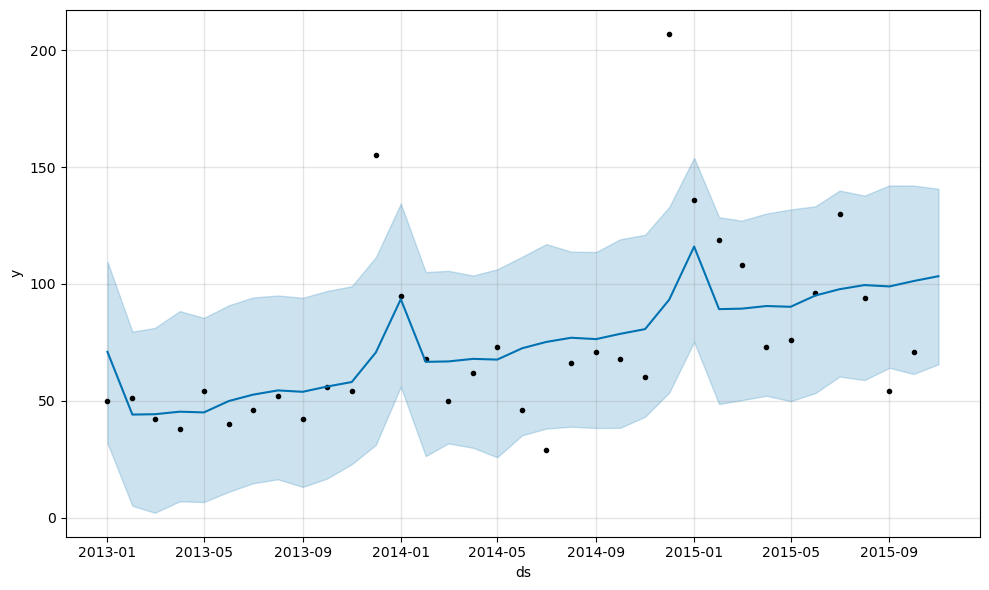

best_preds:  103.32066342307007

getting best preds for s31_ c65
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 163.24      119.68      209.49
33 2015-10-01 165.92      120.68      210.59
34 2015-11-01 170.37      129.37      217.87


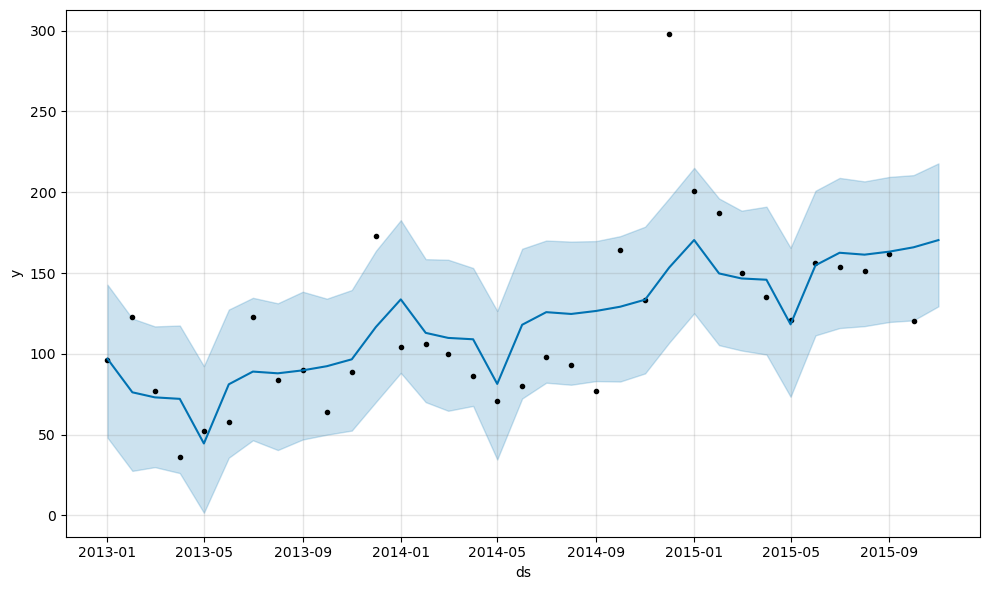

best_preds:  170.37316473491734

getting best preds for s31_ c67
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 52.98       16.65       88.41
33 2015-10-01 52.28       13.91       88.20
34 2015-11-01 52.18       16.52       90.35


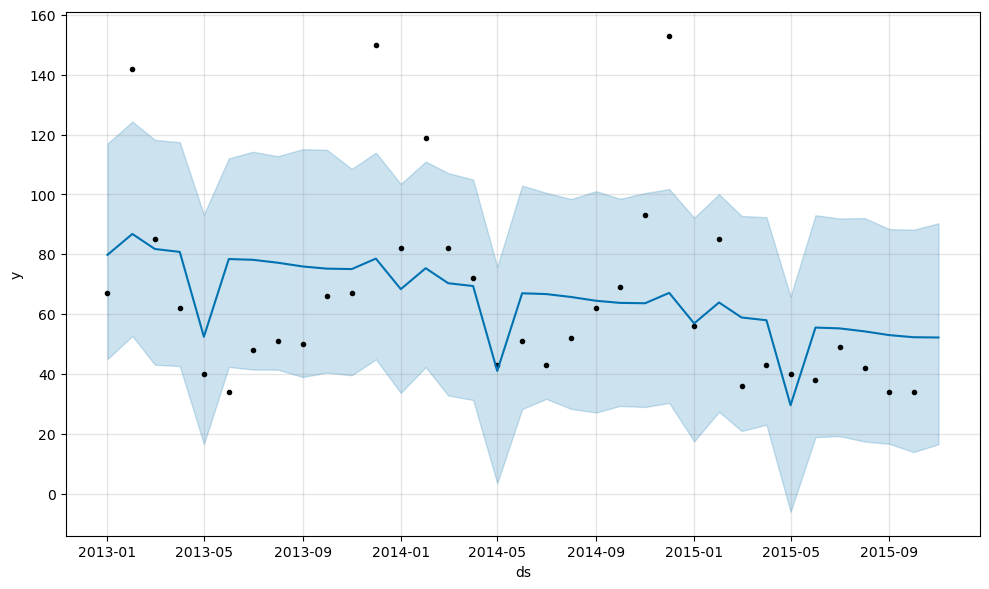

best_preds:  52.18330146680209

getting best preds for s31_ c69
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 83.55       55.74      109.64
33 2015-10-01 86.94       59.61      114.79
34 2015-11-01 92.27       61.31      118.88


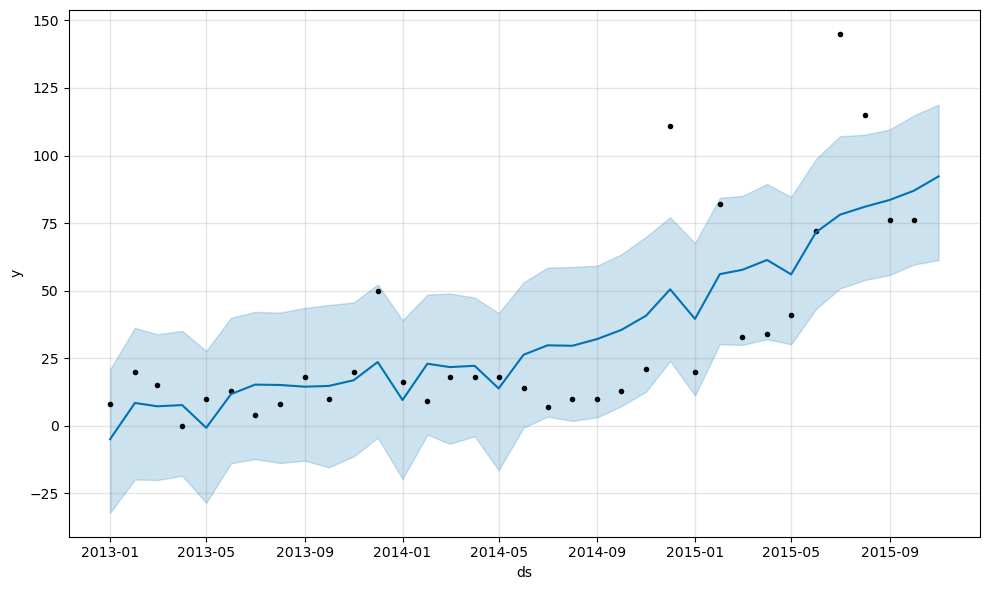

best_preds:  92.2734695124997

getting best preds for s31_ c7
2014-09-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.31        8.40       28.12
33 2015-10-01 18.00        8.08       27.27
34 2015-11-01 20.64       10.99       30.66


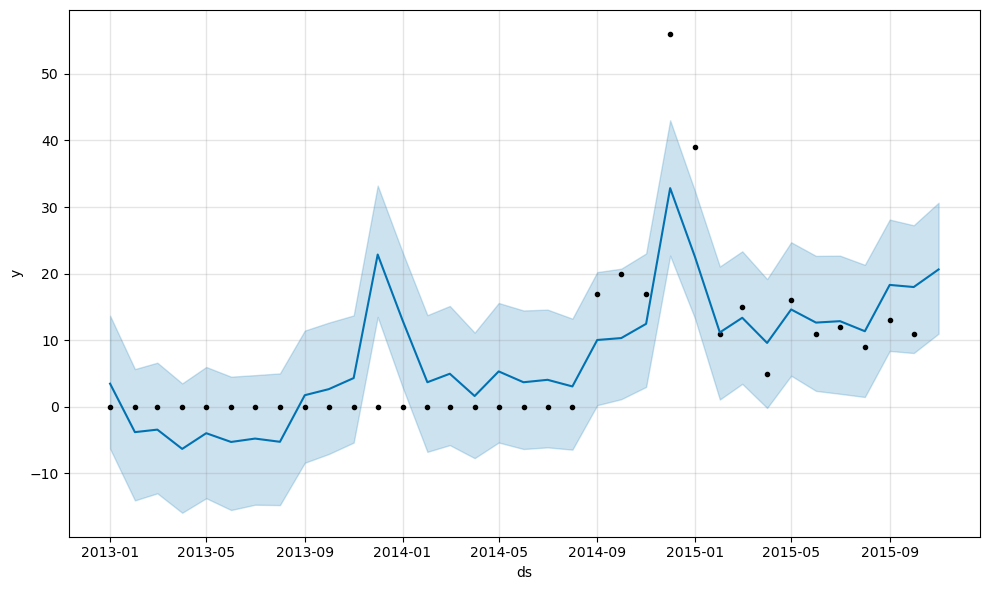

best_preds:  20.63693550951613

getting best preds for s31_ c70
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 112.39       76.87      144.98
33 2015-10-01 117.81       82.77      152.07
34 2015-11-01 124.85       88.77      161.09


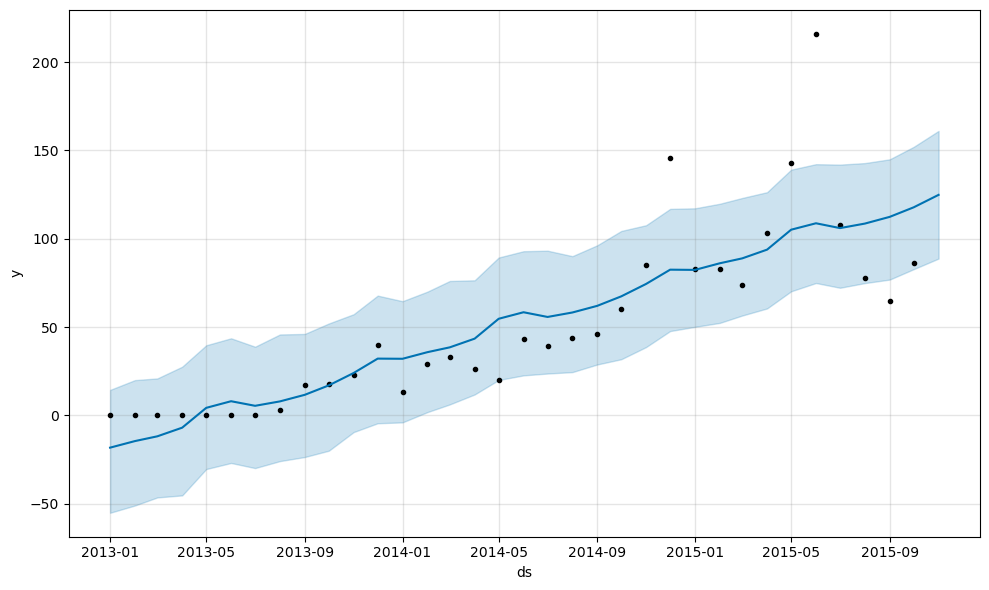

best_preds:  124.851472632307

getting best preds for s31_ c71
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 21.25       14.07       28.31
33 2015-10-01 21.50       14.43       29.27
34 2015-11-01 21.78       14.24       29.26


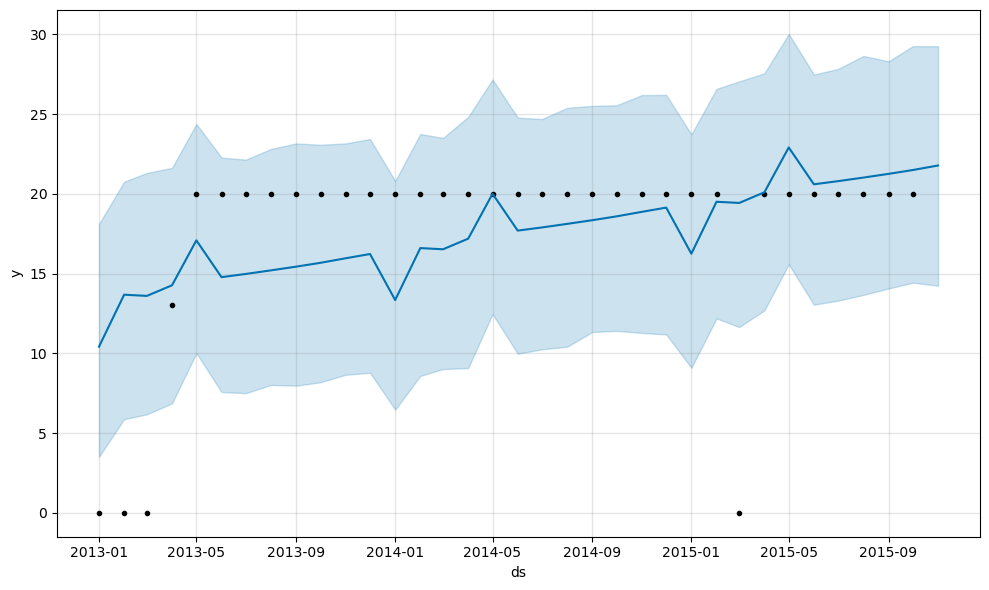

best_preds:  21.77809491937683

getting best preds for s31_ c72
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds   yhat  yhat_lower  yhat_upper
32 2015-09-01 101.75       62.76      136.62
33 2015-10-01 103.49       64.70      138.14
34 2015-11-01 103.61       69.35      141.08


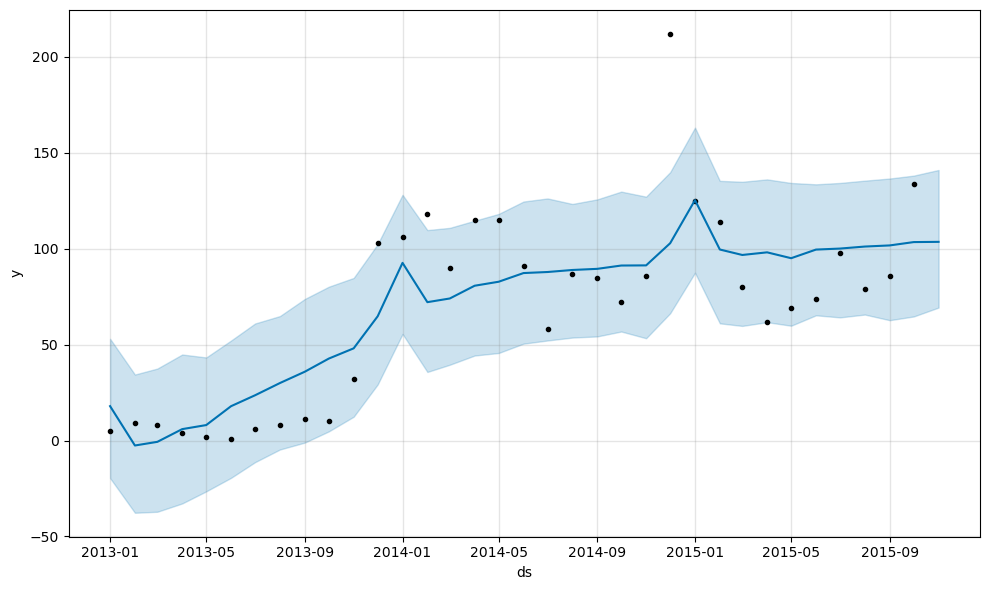

best_preds:  103.60738369392284

getting best preds for s31_ c73
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 18.10       11.84       23.72
33 2015-10-01 19.46       13.40       26.00
34 2015-11-01 19.23       12.94       25.41


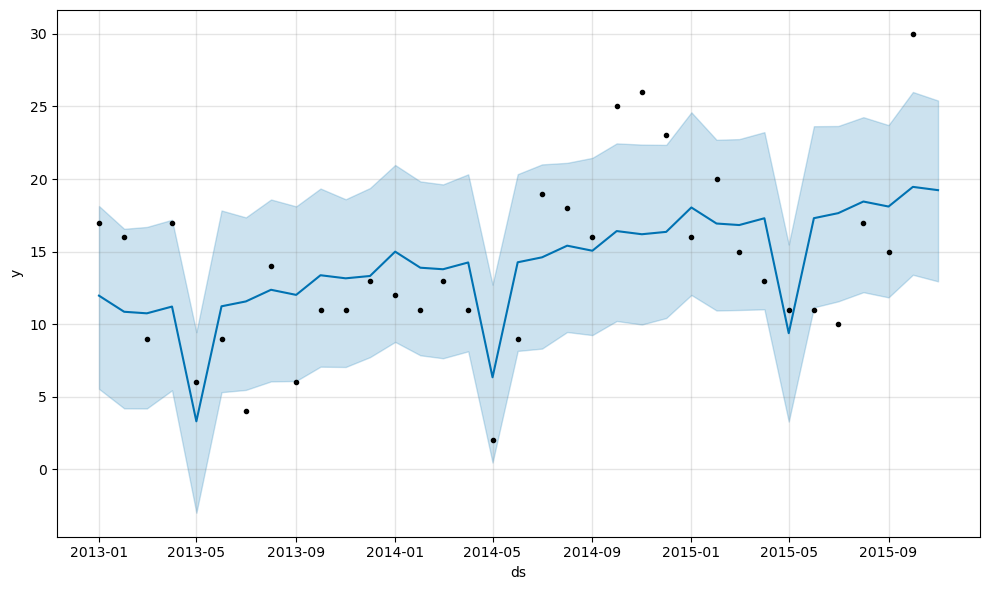

best_preds:  19.231768835837943

getting best preds for s31_ c74
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


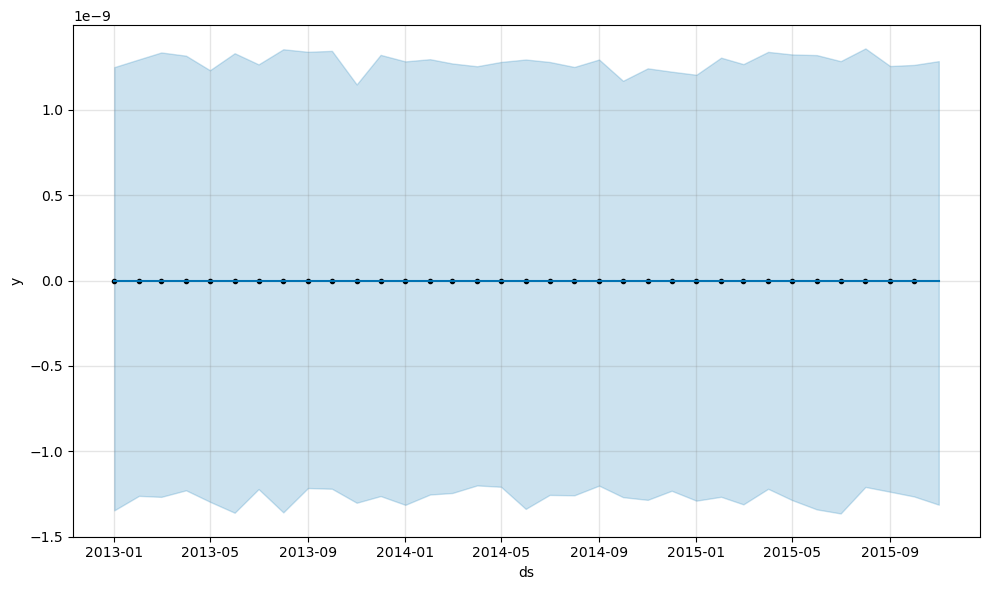

best_preds:  0.0

getting best preds for s31_ c75
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 57.62       52.54       62.37
33 2015-10-01 70.19       64.97       75.36
34 2015-11-01 58.44       53.39       63.29


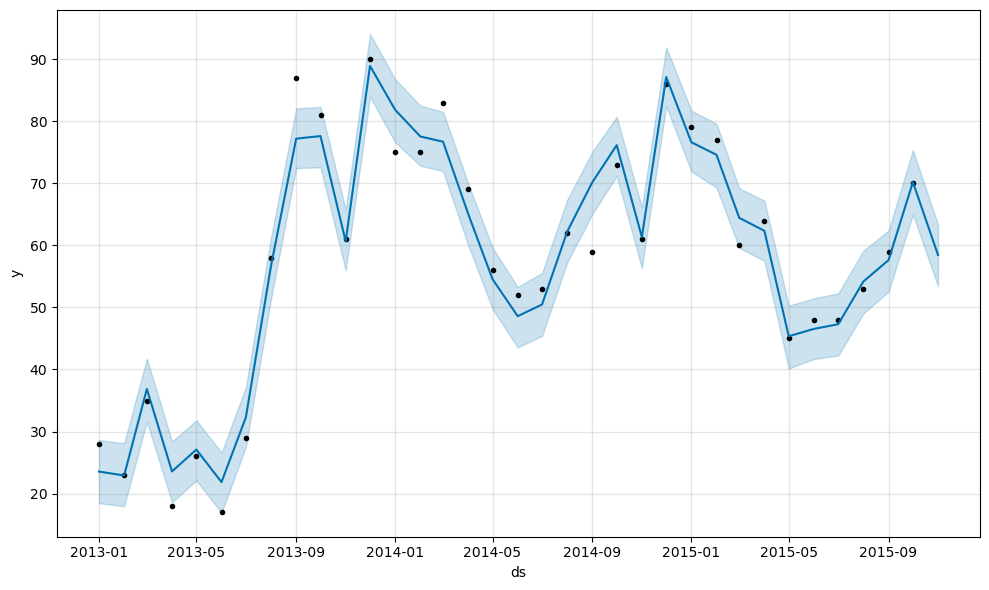

best_preds:  58.43914174092938

getting best preds for s31_ c76
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


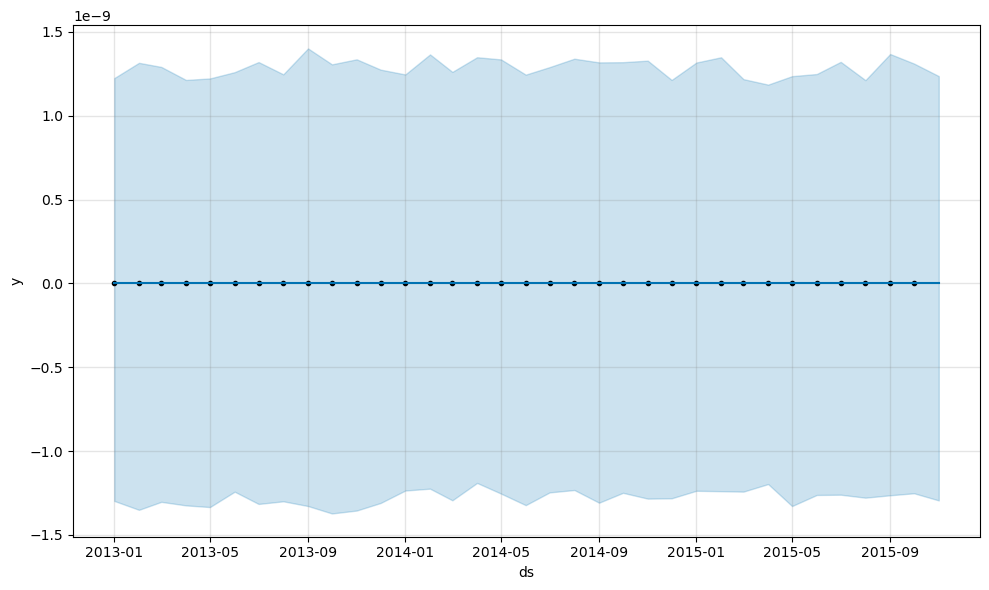

best_preds:  0.0

getting best preds for s31_ c77
2014-04-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.04       -0.34        0.46
33 2015-10-01  0.04       -0.35        0.41
34 2015-11-01  0.07       -0.32        0.47


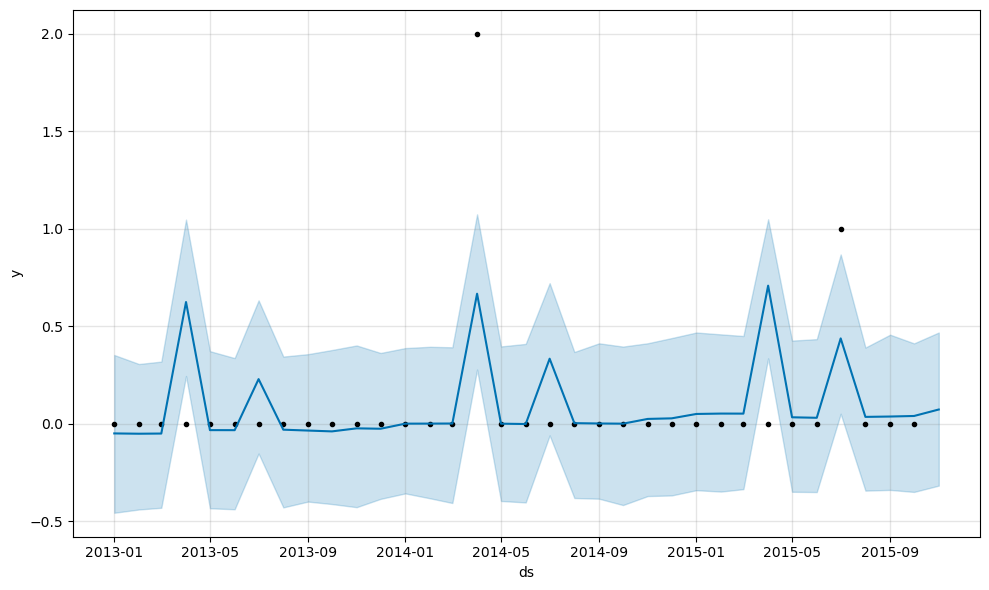

best_preds:  0.07319856992511589

getting best preds for s31_ c78
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


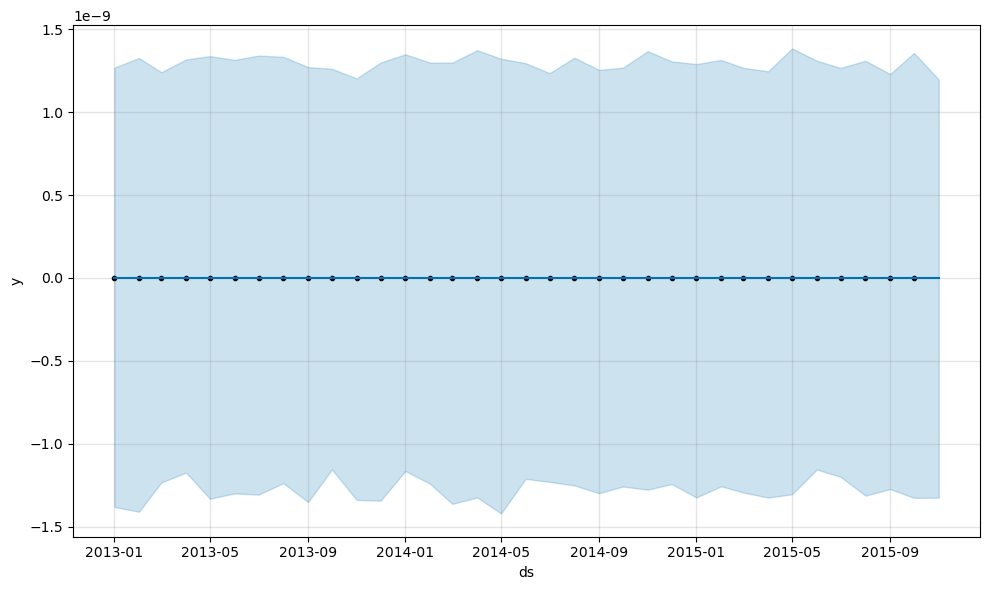

best_preds:  0.0

getting best preds for s31_ c79
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 21.14       14.04       27.78
33 2015-10-01 21.65       15.16       28.05
34 2015-11-01 22.19       15.71       28.38


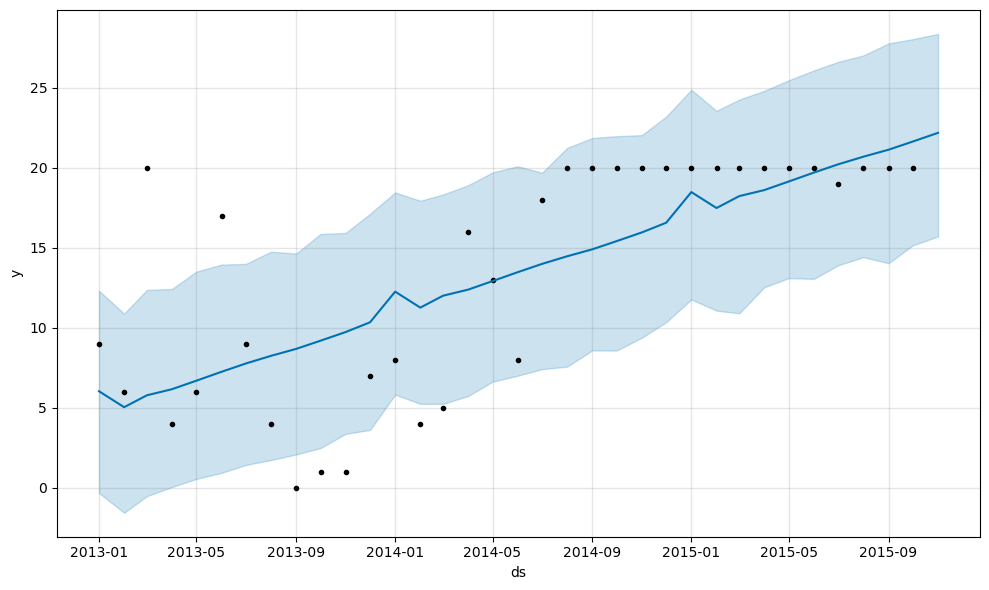

best_preds:  22.192756176805492

getting best preds for s31_ c83
{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.5}
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01 28.70       18.17       38.36
33 2015-10-01 32.54       22.44       41.83
34 2015-11-01 27.96       18.44       37.39


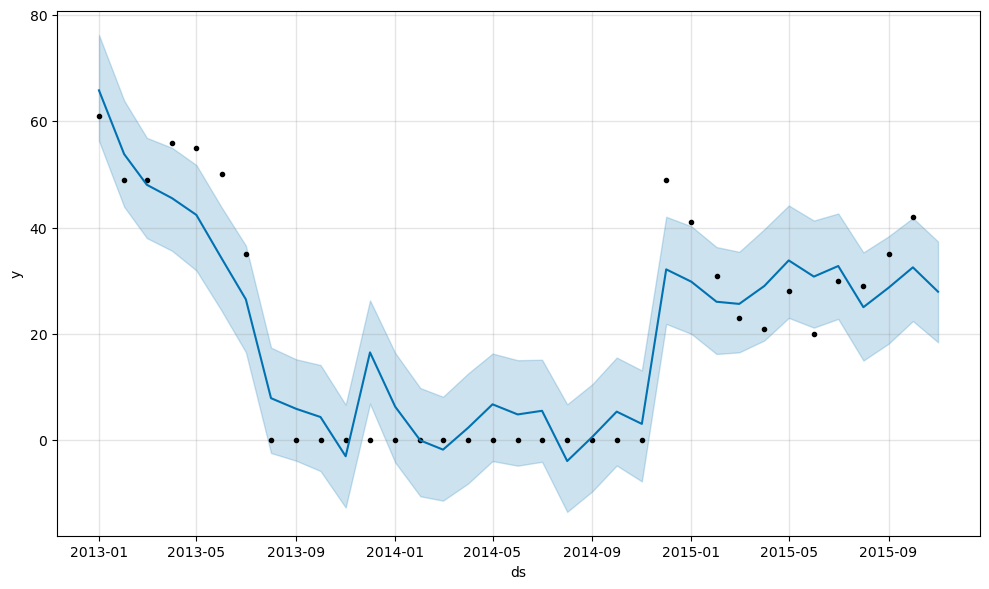

best_preds:  27.95506555730319

getting best preds for s31_ c9
2013-01-01 00:00:00
too many zero values, return default best params
           ds  yhat  yhat_lower  yhat_upper
32 2015-09-01  0.00       -0.00        0.00
33 2015-10-01  0.00       -0.00        0.00
34 2015-11-01  0.00       -0.00        0.00


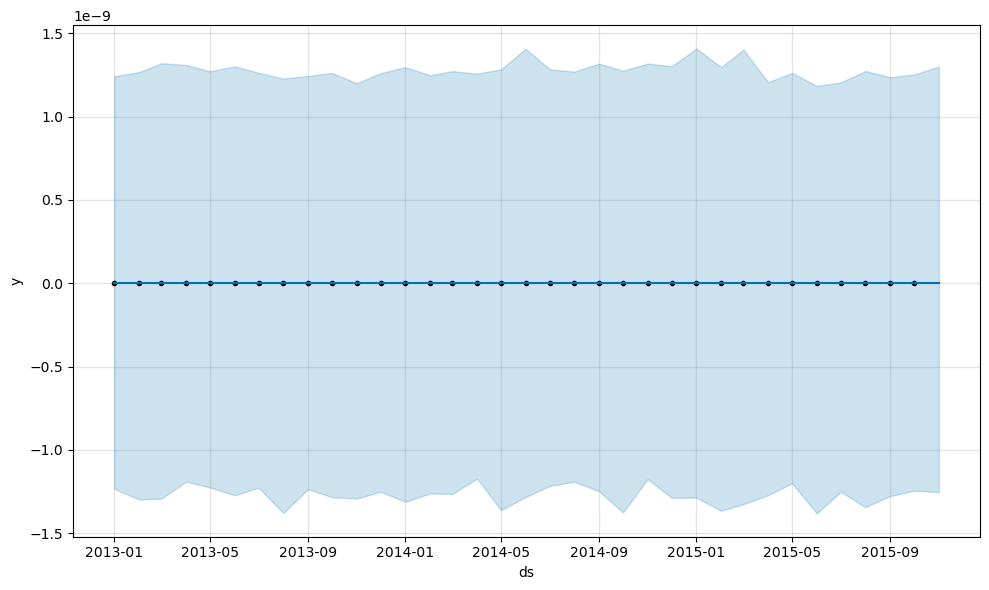

best_preds:  0.0
Wall time: 19min 29s


In [21]:
%%time
    
shop_id = 31
    
print(f'\n\nforecasting shop: s{shop_id}')
    
####read pickle_dict, which store everything
#############################################
pickle_dict_oneshop = pickle.load(open(f'../temp/s{shop_id}_hier.pkl', 'rb'))
df_hier  = pickle_dict_oneshop['df_hier']
tree = pickle_dict_oneshop['tree']
sum_mat = pickle_dict_oneshop['sum_mat']
sum_mat_labels =pickle_dict_oneshop['sum_mat_labels']
oneshop_cat_list = pickle_dict_oneshop['oneshop_cat_list']
oneshop_item_list = pickle_dict_oneshop['oneshop_item_list']


################### creat train, validation,and test dataset
###########################################################################
df_hier_train = df_hier.loc[df_hier.index <= '2015-10-01']
df_hier_test = df_hier.loc[df_hier.index == '2015-11-01']


    
forecasts = pd.DataFrame(columns = df_hier.columns, index=['fake'])
    
    
################### forecasting total sales in this shop
#################################################################
print('\ngetting best preds for forecast_total_sales')
forecasts['total'] = [get_best_preds(df_hier_train, 'total')]

    
################### forecasting all category sales in this shop
#################################################################
#dataframe to hold the forecasts
for cat in oneshop_cat_list:
    print(f'\ngetting best preds for s{shop_id}_', cat)
    forecasts[cat] = [get_best_preds(df_hier_train, cat)]


###########save neccessary object to pickle_dict, 
############################################################################
#pickle_dict_oneshop_new = dict()
#pickle_dict_oneshop_new['forecasts']=forecasts
#pickle.dump(pickle_dict_oneshop_new, open(f'../temp/s{shop_id}_forecasts.pkl', 'wb'))

